# Libraries and Settings

In [107]:
from lib_mitotic_waves import *

import sys
sys.path.append('packages') # This is the folder where I ussually have lib_datayang_owen
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcol
import scipy.stats as stats
lowess = sm.nonparametric.lowess
from matplotlib import rc,rcParams,colors
from matplotlib.colors import LinearSegmentedColormap
from skimage import io
from skimage.restoration import inpaint
from scipy import signal


## Default parameters

In [2]:
p_0 = {'ks':1.5,
       'a_cdc25':0.8, 'b_cdc25':4, 'ec50_cdc25':35, 'n_cdc25':11,
       'a_wee1':0.4, 'b_wee1':2, 'ec50_wee1':30, 'n_wee1':3.5,
       'a_deg':0.01, 'b_deg':0.06, 'ec50_deg':32, 'n_deg':17,
       'Da':1,'Di':1,'tau':1,'alpha':1,'beta':1}
Da_u = 240*1e-6 # mm*2/min
chi = np.sqrt(Da_u)

# Load and Clean Kymographs

## Load Each Kymograph

In [3]:
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

# Import data from folder
exceptions = [r'temp/030222 (Cdc25 Inhib)/Pos1_Tube2_Ratio_Montage_TimeBinned.tif', # High resolution
              r'temp/030222 (Cdc25 Inhib)/Pos1_Tube2_Ratio_Montage_UnBinned.tif', # High resolution
              r'temp/030222 (Cdc25 Inhib)/Pos7 (40 uM no nuc)/Tube1Ratio_Montage.tif', # Full of NaNs
              r'temp/063021 (CSF)/Pos3 (nuc)/Tube2Ratio_Montage.tif',
              r'temp/063021 (CSF_Cont)/Pos5 (no nuc)/Tube2_Ratio_New_Montage.tif']# Full of NaNs

dir_dd = get_directory_structure(r'temp/',r'temp/Tube_Lengths_New.xlsx',exceptions)

for k,v in dir_dd['temp'].items():
    for kk,vv in v.items():
        for kkk,vvv in vv.items():
            vvv['x'] = vvv['x']*1e3 # Use micrometers

for kk,vv in dir_dd['temp']['080421 (CSF)'].items():
    for kkk,vvv in vv.items():
        vvv['Activity'] = np.flip(vvv['Activity'],axis=0)
        
for kk,vv in dir_dd['temp']['063021 (CSF)'].items():
    for kkk,vvv in vv.items():
        vvv['Activity'] = np.flip(vvv['Activity'],axis=0)

# CLEANING
# Define limits
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos6 (2.0 uM nuc)']['Tube5Ratio_Montage.tif']['limits'] = [11,-5,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos6 (2.0 uM nuc)']['Tube4Ratio_Montage.tif']['limits'] = [0,-13,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos4 (20 uM nuc)']['Tube1Ratio_Montage.tif']['limits'] = [20,-1,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos4 (20 uM nuc)']['Tube2Ratio_Montage.tif']['limits'] = [5,-1,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos6 (40 uM nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,-1,10,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [0,-7,0,-15]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [5,-25,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos2 (10 uM nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,-5,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos2 (10 uM nuc)']['Tube2Ratio_Montage.tif']['limits'] = [2,-1,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos5 (20 uM no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [2,-1,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos5 (20 uM no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,-5,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos5 (20 uM no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [2,-1,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos5 (20 uM no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [5,-1,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos5 (20 uM no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [13,-5,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos3 (10 uM no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [5,-1,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos3 (10 uM no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [2,-1,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM nuc)']['Tube1Ratio_Montage.tif']['limits'] = [2,-1,0,-50]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,-1,0,-40]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM nuc)']['Tube3Ratio_Montage.tif']['limits'] = [2,-2,0,-50]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos7 (40 uM no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [2,40,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos7 (40 uM no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [10,40,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos7 (40 uM no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [10,35,0,-1]
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos7 (40 uM no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,-1,10,-1]

dir_dd['temp']['032322 (Wee1 Inhib)']['Pos3 (0.5 uM no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [0,-1,0,200]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos3 (0.5 uM no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [5,-1,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos3 (0.5 uM no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [5,-1,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos6 (2.0 uM nuc)']['Tube1Ratio_Montage.tif']['limits'] = [5,-1,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos6 (2.0 uM nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,-1,0,196]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos6 (2.0 uM nuc)']['Tube3Ratio_Montage.tif']['limits'] = [5,-5,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos6 (2.0 uM nuc)']['Tube5Ratio_Montage.tif']['limits'] = [5,-1,0,210]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos7 (2.0 uM no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [10,-1,0,230]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos7 (2.0 uM no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [20,-1,0,260]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos7 (2.0 uM no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [15,-1,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube2Ratio_Montage.tif']['limits'] = [13,-1,0,230]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube5Ratio_Montage.tif']['limits'] = [5,-1,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [5,-1,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [5,-1,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [10,-1,0,270]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,-1,0,250]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube6Ratio_Montage.tif']['limits'] = [3,-3,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,-1,0,210]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)']['Tube3Ratio_Montage.tif']['limits'] = [5,-1,0,230]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube2Ratio_Montage.tif']['limits'] = [15,-1,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube3Ratio_Montage.tif']['limits'] = [10,-1,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube4Ratio_Montage.tif']['limits'] = [13,-1,0,-1]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,-1,0,210]
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube5Ratio_Montage.tif']['limits'] = [15,-1,0,250]

dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [10,-1,0,-1]
dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,70,0,-1]
dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [5,80,0,130]
dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [10,80,0,71]
dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,69,0,-1]
dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [20,80,0,80]
dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [21,80,0,70]
dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [36,90,0,120]
dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [14,90,0,100]
dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [5,85,0,-1]
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif']['limits'] = [5,80,0,-1]
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube4Ratio_Montage.tif']['limits'] = [10,80,0,150]
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube1Ratio_Montage.tif']['limits'] = [5,55,0,-1]
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube3Ratio_Montage.tif']['limits'] = [10,80,0,130]
dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube2Ratio_Montage.tif']['limits'] = [2,80,0,120]
dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif']['limits'] = [5,72,0,-1]
dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,75,0,-1]
dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,65,0,150]
dir_dd['temp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube1_Ratio_Montage.tif']['limits'] = [4,-1,0,170]
dir_dd['temp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube4_Ratio_Montage.tif']['limits'] = [4,-1,0,200]
dir_dd['temp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube5_Ratio_Montage.tif']['limits'] = [0,-1,0,200]

dir_dd['temp']['063021 (CSF)']['Pos6 (no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [0,50,0,230]
dir_dd['temp']['063021 (CSF)']['Pos6 (no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [27,60,0,140]
dir_dd['temp']['063021 (CSF)']['Pos6 (no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [8,50,0,100]
dir_dd['temp']['063021 (CSF)']['Pos6 (no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,45,0,200]
dir_dd['temp']['063021 (CSF)']['Pos7 (no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,65,0,200]
dir_dd['temp']['063021 (CSF)']['Pos7 (no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [0,65,0,250]
dir_dd['temp']['063021 (CSF)']['Pos7 (no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [0,40,0,200]
dir_dd['temp']['063021 (CSF)']['Pos7 (no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,40,0,140]
dir_dd['temp']['063021 (CSF)']['Pos7 (no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,40,0,100]
dir_dd['temp']['063021 (CSF)']['Pos2 (nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,60,0,75]
dir_dd['temp']['063021 (CSF)']['Pos2 (nuc)']['Tube3Ratio_Montage.tif']['limits'] = [0,60,0,200]
dir_dd['temp']['063021 (CSF)']['Pos2 (nuc)']['Tube4Ratio_Montage.tif']['limits'] = [0,60,0,150]
dir_dd['temp']['063021 (CSF)']['Pos2 (nuc)']['Tube1Ratio_Montage.tif']['limits'] = [15,60,0,160]
dir_dd['temp']['063021 (CSF)']['Pos2 (nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,60,0,200]
dir_dd['temp']['063021 (CSF)']['Pos4 (nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,60,0,120]
dir_dd['temp']['063021 (CSF)']['Pos4 (nuc)']['Tube3Ratio_Montage.tif']['limits'] = [21,60,0,100]
dir_dd['temp']['063021 (CSF)']['Pos4 (nuc)']['Tube4Ratio_Montage.tif']['limits'] = [5,60,0,120]
dir_dd['temp']['063021 (CSF)']['Pos4 (nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,70,0,190]
dir_dd['temp']['063021 (CSF)']['Pos4 (nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,80,0,180]
dir_dd['temp']['063021 (CSF)']['Pos8 (no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [4,60,0,120]
dir_dd['temp']['063021 (CSF)']['Pos8 (no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [4,60,0,240]
dir_dd['temp']['063021 (CSF)']['Pos8 (no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [8,60,0,200]
dir_dd['temp']['063021 (CSF)']['Pos8 (no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [3,60,0,200]
dir_dd['temp']['063021 (CSF)']['Pos3 (nuc)']['Tube3Ratio_Montage.tif']['limits'] = [0,60,0,120]
dir_dd['temp']['063021 (CSF)']['Pos3 (nuc)']['Tube4Ratio_Montage.tif']['limits'] = [2,60,0,190]
dir_dd['temp']['063021 (CSF)']['Pos3 (nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,60,0,150]
dir_dd['temp']['063021 (CSF)']['Pos3 (nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,60,0,160]

# Add pixels at the begining (at time 0)
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos6 (40 uM nuc)']['Tube3Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos6 (40 uM nuc)']['Tube3Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos3 (0.5 uM no nuc)']['Tube5Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos3 (0.5 uM no nuc)']['Tube5Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube4Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube5Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube5Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube4Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube5Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube5Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube6Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM no nuc)']['Tube6Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube1Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube1Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube2Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube2Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube3Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube3Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube4Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube5Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube5Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube1Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube1Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube2Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube2Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube3Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube3Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube4Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube5Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube5Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube3Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube3Ratio_Montage.tif'],10)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube4Ratio_Montage.tif'],10)
array = dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube4Ratio_Montage.tif']['Activity'].copy()
array[:,10] = array[:,11]*1.2
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube4Ratio_Montage.tif']['Activity'] = array.copy()

dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube1Ratio_Montage.tif'] =  add_pixels(dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube1Ratio_Montage.tif'],10)
array = dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube1Ratio_Montage.tif']['Activity'].copy()
array[:,10] = array[:,11]*1.2
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos2 (0.5 uM nuc)']['Tube1Ratio_Montage.tif']['Activity'] = array.copy()

dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube1Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube1Ratio_Montage.tif'],10)
dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube2Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube2Ratio_Montage.tif'],10)
dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube3Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube3Ratio_Montage.tif'],10)
array = dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube3Ratio_Montage.tif']['Activity'].copy()
array[:,10] = array[:,11]*1.2
dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube3Ratio_Montage.tif']['Activity'] = array.copy()
dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube4Ratio_Montage.tif'],10)
dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube1Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube1Ratio_Montage.tif'],10)
dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube5Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube5Ratio_Montage.tif'],10)
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif'],10)
array = dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif']['Activity'].copy()
array[:33,10] = array[:33,11]*1.5
array[78:,10] = array[78:,11]*1.5
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif']['Activity'] = array.copy()
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube4Ratio_Montage.tif'],10)
array = dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube4Ratio_Montage.tif']['Activity'].copy()
array[:,10] = array[:,11]*1.2
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube4Ratio_Montage.tif']['Activity'] = array.copy()
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube1Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube1Ratio_Montage.tif'],10)
array = dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube1Ratio_Montage.tif']['Activity'].copy()
array[30:,10] = array[30:,11]*1.5
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube1Ratio_Montage.tif']['Activity'] = array.copy()
dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube2Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube2Ratio_Montage.tif'],10)
array = dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube2Ratio_Montage.tif']['Activity'].copy()
array[35:45,10] = array[35:45,11]*1.5
dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube2Ratio_Montage.tif']['Activity'] = array.copy()
dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif'],10)
array = dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif']['Activity'].copy()
array[22:37,10] = array[22:37,11]*1.5
dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif']['Activity'] = array.copy()

dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube1Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube1Ratio_Montage.tif'],10)
dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube5Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube5Ratio_Montage.tif'],10)
array = dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube5Ratio_Montage.tif']['Activity'].copy()
array[10:15,10] = array[10:15,11]*1.5
dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube5Ratio_Montage.tif']['Activity'] = array.copy()

dir_dd['temp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube1_Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube1_Ratio_Montage.tif'],10)
dir_dd['temp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube5_Ratio_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube5_Ratio_Montage.tif'],10)

dir_dd['temp']['080421 (CSF_Cont)']['Pos4 (nuc)']['Tube1_Ratio_New_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF_Cont)']['Pos4 (nuc)']['Tube1_Ratio_New_Montage.tif'],10)
dir_dd['temp']['080421 (CSF_Cont)']['Pos4 (nuc)']['Tube2_Ratio_New_Montage.tif'] = add_pixels(dir_dd['temp']['080421 (CSF_Cont)']['Pos4 (nuc)']['Tube2_Ratio_New_Montage.tif'],10)


# Correct a few pixel rows with neighbours
array = dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube6Ratio_Montage.tif']['Activity'].copy()
i = 80
array[i]= (array[i+2] + array[i-2])/2
array[i+1] = array[i+2]+0
array[i-1] = array[i-2]+0
array[85:90,210:] = np.average(array[85:90,210:])
dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube6Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube1Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 92,102,170+10,171+10
array[:,10] = array[:,11]*1.2
array[i0:i1,j0:j1] = (array[i0:i1,j0-1:j1-1] + array[i0:i1,j0+1:j1+1])/2
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube1Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube2Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 82,94,170+10,171+10
array[i0:i1,j0:j1] = (array[i0:i1,j0-1:j1-1] + array[i0:i1,j0+1:j1+1])/2
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube2Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube3Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 80,91,170+10,171+10
array[i0:i1,j0:j1] = (array[i0:i1,j0-1:j1-1] + array[i0:i1,j0+1:j1+1])/2
array[:,10] = array[:,11]*1.2
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube3Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube4Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 90,99,170+10,171+10
array[i0:i1,j0:j1] = (array[i0:i1,j0-1:j1-1] + array[i0:i1,j0+1:j1+1])/2
array[:,10] = array[:,11]*1.2
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube4Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube5Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 87,98,170+10,171+10
array[i0:i1,j0:j1] = (array[i0:i1,j0-1:j1-1] + array[i0:i1,j0+1:j1+1])/2
array[:,10] = array[:,11]*1.4
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos4 (1.0 uM nuc)']['Tube5Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube2Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 75,90,235,-1
array[i0:i1,j0:j1] = np.average(array[i0-10:i1+10,j0:j1],axis=0)
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos5 (1.0 uM no nuc)']['Tube2Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)']['Tube3Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 0,30,198,230
array[i0:i1,j0:j1] = np.average(array[i0:i1,j0:j1])
i0,i1,j0,j1 = -30,-1,198,230
array[i0:i1,j0:j1] = np.average(array[i0:i1,j0:j1])
dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)']['Tube3Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube3Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 20,42,0,4
array[i0:i1,j0:j1] = np.average(array[np.logical_and(~np.isnan(array),array!= np.inf)])
dir_dd['temp']['080421 (CSF)']['Pos3 (no nuc)']['Tube3Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 65,-1,140,-1
array[i0:i1,j0:j1] = np.average(array[np.logical_and(~np.isnan(array),array!= np.inf)])
dir_dd['temp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['063021 (CSF)']['Pos2 (nuc)']['Tube1Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 50,-1,50,-1
array[i0:i1,j0:j1] = np.average(array[np.logical_and(~np.isnan(array),array!= np.inf)])
dir_dd['temp']['063021 (CSF)']['Pos2 (nuc)']['Tube1Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['063021 (CSF)']['Pos2 (nuc)']['Tube5Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 40,-1,70,-1
array[i0:i1,j0:j1] = np.average(array[np.logical_and(~np.isnan(array),array!= np.inf)])
dir_dd['temp']['063021 (CSF)']['Pos2 (nuc)']['Tube5Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['063021 (CSF)']['Pos4 (nuc)']['Tube4Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 35,-1,40,200
array[i0:i1,j0:j1] = np.average(array[np.logical_and(~np.isnan(array),array!= np.inf)])
dir_dd['temp']['063021 (CSF)']['Pos4 (nuc)']['Tube4Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['temp']['063021 (CSF)']['Pos3 (nuc)']['Tube5Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 37,43,0,-1
array[i0:i1] = (array[i0] + array[i1])/2
dir_dd['temp']['063021 (CSF)']['Pos3 (nuc)']['Tube5Ratio_Montage.tif']['Activity'] = array.copy()

In [ ]:
data_saved = np.load('expt_data.npz')
dat_con = data_saved['dat_con_s']
dat_con_n = data_saved['dat_con_n_s']
data_t = data_saved['data_t_s']
data_t_n = data_saved['data_t_n_s']

# Figures 1 (w/o nuclei) and 3 (w/ nuclei)

## Single Kymograph (w/o nuclei)

/home/owpuls/mitotic_waves/lib_mitotic_waves.py:516: RuntimeWarning: divide by zero encountered in true_divide
  speeds = np.gradient(el[1],1)/np.gradient(el[0],1)
/home/owpuls/mitotic_waves/lib_mitotic_waves.py:544: RuntimeWarning: invalid value encountered in subtract
  local_dev = arr - local_avg


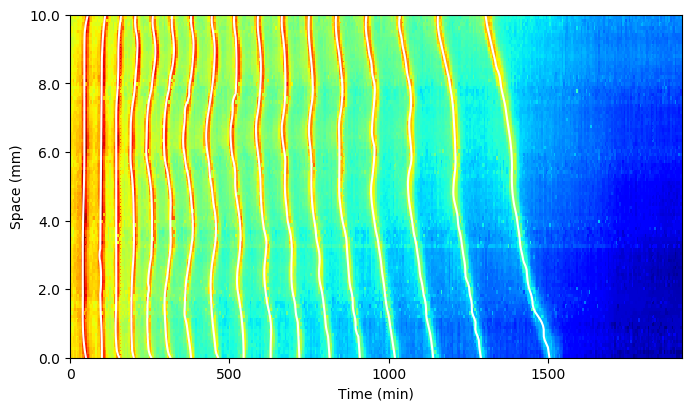

In [43]:
dir_single = dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube4Ratio_Montage.tif']
dat_single = extract_data_v1(dir_single)

size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax = plt.gca()
dat_single = extract_data_plt(ax,dir_single,[0,500,1000,1500],flip=True,plot_crop=True,plot_traj=False,plot_cur=True)
# fig.savefig('dani_figs/chem_singleTube_Cdc25Tube4_NoNuc_Trajectories.svg', bbox_inches='tight', dpi=1200)
plt.show()

### FRET Ratio Timecourse

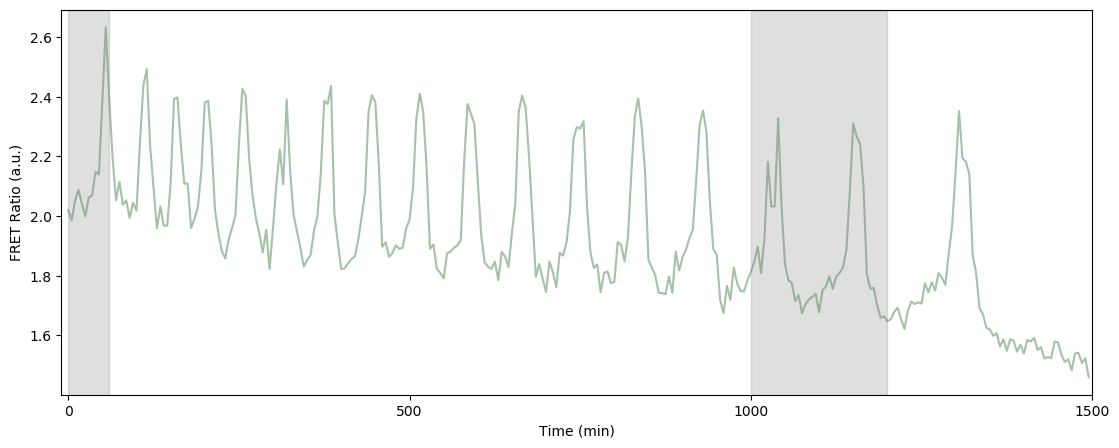

In [49]:
size = 5
fig=plt.figure(figsize=(2.66*size,size))
dt=5.0

act = dir_single['Activity'][0,:300]
plt.plot(dir_single['t'][:300],act,'#A4C2A5',zorder=-10)
temp = dat_single[np.argwhere(dat_single[:,-3]==dir_single['x'][0]),-2]
temptemp = temp[:,0]/5
plt.scatter(temp,act[temptemp.astype('int')],c='#574D68')
plt.axvspan(0.0,60.0,color='grey',alpha=0.25)
plt.axvspan(1000.0,1200.0,color='grey',alpha=0.25)

plt.xlabel('Time (min)')
plt.ylabel('FRET Ratio (a.u.)')
plt.xlim([-10,1500])
plt.xticks(ticks=[0,500,1000,1500],labels=['0','500','1000','1500'])
# fig.savefig('dani_figs/chem_singleTube_Cdc25Tube4_FRETRatio.svg', bbox_inches='tight', dpi=300)
plt.show()

### Spatial Profiles Over Time

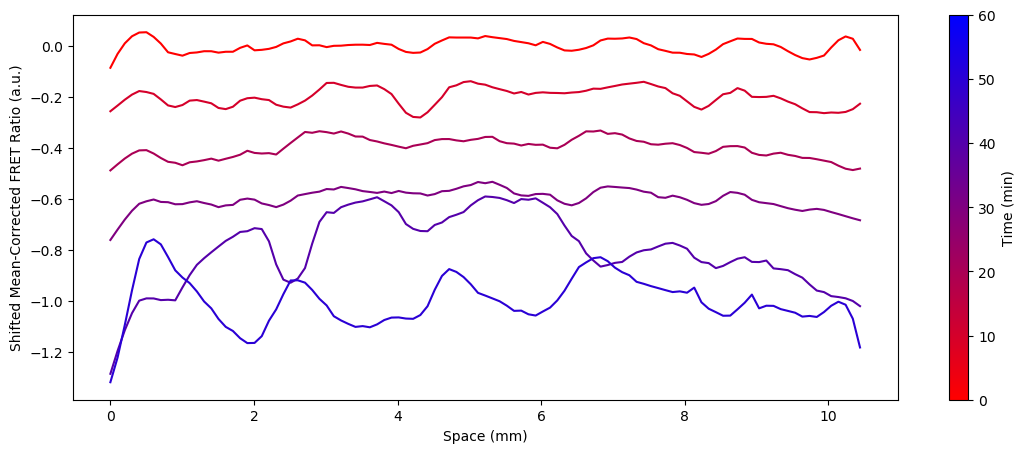

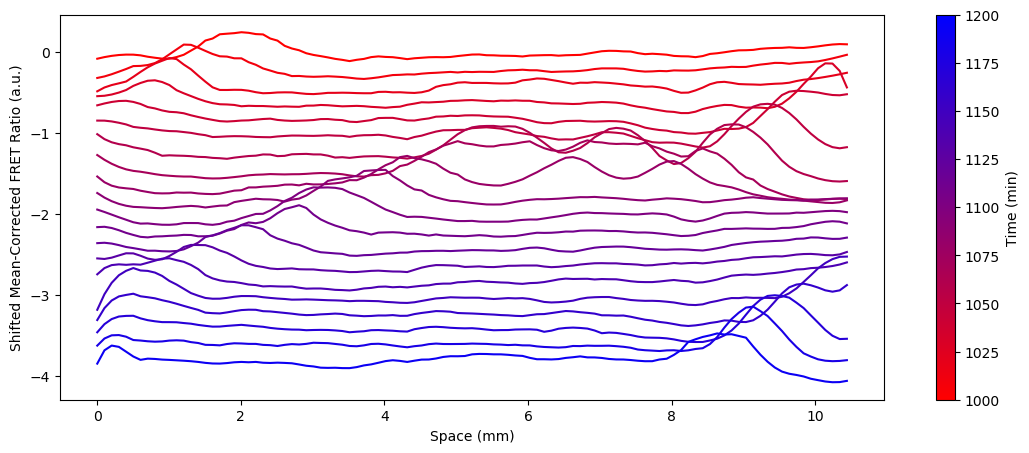

In [79]:
# fig1, axs1 = plt.subplots(1, 2,figsize=(15,5))
# plt.figure(figsize=(20,5))
names = ['temp/030222 (Cdc25 Inhib)/Pos1 (0 uM no nuc)/Tube4Ratio_Montage.tif']

orig_image = io.imread(names[0])
spc=10.44
dt = 5.0

filled_cropped_image = inpaint.inpaint_biharmonic(orig_image, np.isnan(orig_image))
# filled_cropped_image = dir_single['Activity']

## Detrend Data
# Calculate the average FRET ratio at the beginning and end of the image
start_trend = np.mean(filled_cropped_image[:,0])
end_trend = np.mean(filled_cropped_image[:,-1])
# Get the total change in FRET ratio
delta_FRET = abs(start_trend - end_trend)
# Assume the decay is linear and detrend the data using this assumption
trendline = np.linspace(0.0, delta_FRET, np.shape(filled_cropped_image)[1])
trend = - np.tile(trendline, (np.shape(filled_cropped_image)[0], 1))
filled_cropped_detrended_image = (filled_cropped_image - trend)
# Rename 
image = filled_cropped_detrended_image

size = 5
fig=plt.figure(figsize=(2.66*size,size))
strt = 0
end = 12
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["red","blue"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=dt*strt,vmax=dt*end)

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
for j in range(strt,end,2):
  temp = signal.savgol_filter(np.flip(image[:,j]),9,3)
  temp2 = signal.detrend(temp)
  temp1 = temp2-np.mean(temp2) - (j - strt)*0.1
  plt.plot((spc/len(image[:,j]))*np.linspace(0,len(temp1),len(temp1)),temp1,color=cpick.to_rgba(dt*j))

plt.colorbar(cpick,fraction=0.15,label='Time (min)')
plt.xlabel('Space (mm)')
plt.ylabel('Shifted Mean-Corrected FRET Ratio (a.u.)')
# plt.savefig('dani_figs/chem_singleTube_Cdc25_Tube4_Frame'+str(strt)+'to'+str(end)+'_ShiftedProfiles.svg', format='svg',dpi=300)
plt.show()

fig=plt.figure(figsize=(2.66*size,size))
strt = 200
end = 240

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=dt*strt,vmax=dt*end)

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
for j in range(strt,end,2):
  temp = signal.savgol_filter(np.flip(image[:,j]),9,3)
  temp2 = signal.detrend(temp)
  temp1 = temp2-np.mean(temp2) - (j - strt)*0.1

  plt.plot((spc/len(image[:,j]))*np.linspace(0,len(temp1),len(temp1)),temp1,color=cpick.to_rgba(dt*j))

plt.colorbar(cpick,fraction=0.15,label='Time (min)')
plt.xlabel('Space (mm)')
plt.ylabel('Shifted Mean-Corrected FRET Ratio (a.u.)')
# plt.savefig('dani_figs/chem_singleTube_Cdc25_Tube4_Frame'+str(strt)+'to'+str(end)+'_ShiftedProfiles.svg', format='svg',dpi=300)
plt.show()

## Single Kymograph (w/ nuclei)

/home/owpuls/mitotic_waves/lib_mitotic_waves.py:516: RuntimeWarning: divide by zero encountered in true_divide
  speeds = np.gradient(el[1],1)/np.gradient(el[0],1)
/home/owpuls/mitotic_waves/lib_mitotic_waves.py:544: RuntimeWarning: invalid value encountered in subtract
  local_dev = arr - local_avg


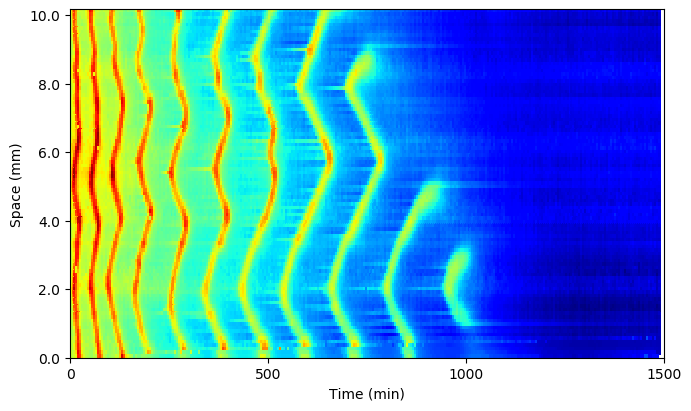

In [60]:
dir_single = dir_dd['temp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)']['Tube2Ratio_Montage.tif']
dat_single = extract_data_v1(dir_single)

size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax = plt.gca()
dat_single = extract_data_plt(ax,dir_single,plot_crop=True,plot_traj=False,plot_cur=False)
# fig.savefig('dani_figs/chem_singleTube_Cdc25Tube4_NoNuc_Trajectories.svg', bbox_inches='tight', dpi=1200)
plt.show()

### Spatial Profiles

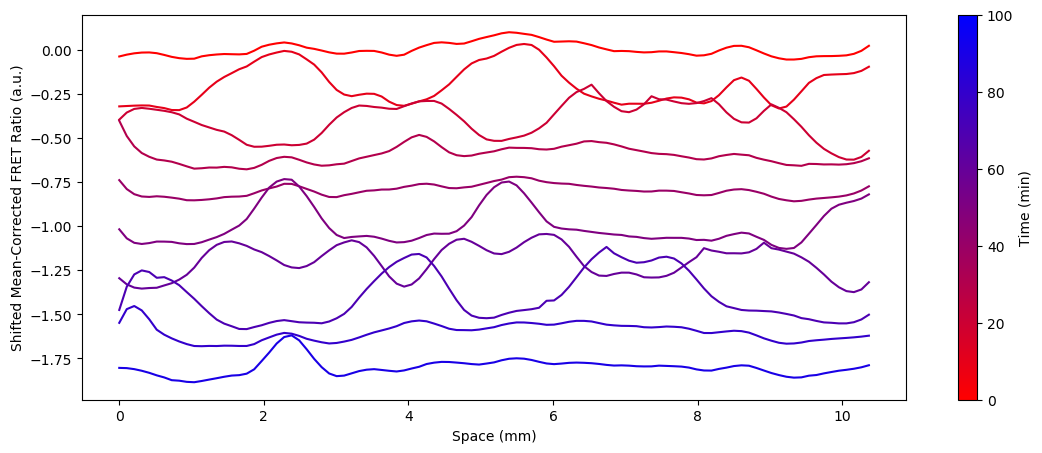

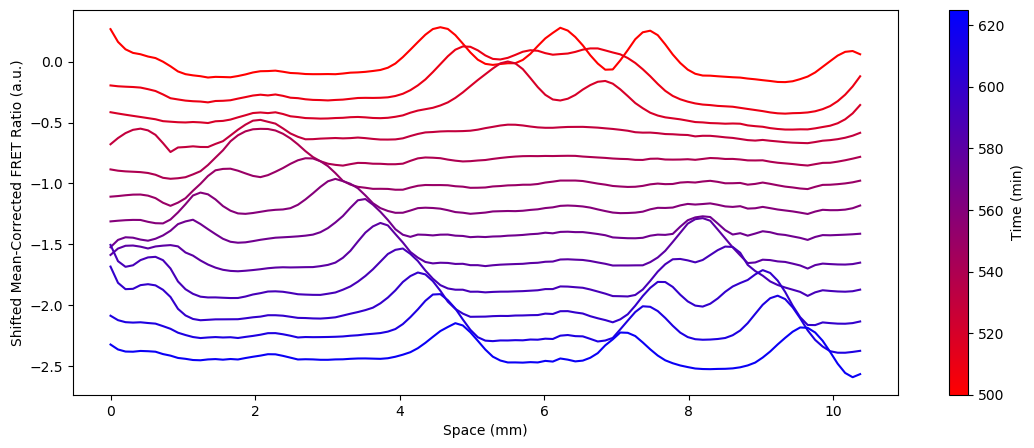

In [90]:
# fig1, axs1 = plt.subplots(1, 2,figsize=(15,5))
# plt.figure(figsize=(20,5))
names = ['temp/032322 (Wee1 Inhib)/Pos1 (0 uM nuc)/Tube2Ratio_Montage.tif']

orig_image = io.imread(names[0])
spc=10.37
dt = 5.0

filled_cropped_image = inpaint.inpaint_biharmonic(orig_image, np.isnan(orig_image))

## Detrend Data
# Calculate the average FRET ratio at the beginning and end of the image
start_trend = np.mean(filled_cropped_image[:,0])
end_trend = np.mean(filled_cropped_image[:,-1])
# Get the total change in FRET ratio
delta_FRET = abs(start_trend - end_trend)
# Assume the decay is linear and detrend the data using this assumption
trendline = np.linspace(0.0, delta_FRET, np.shape(filled_cropped_image)[1])
trend = - np.tile(trendline, (np.shape(filled_cropped_image)[0], 1))
filled_cropped_detrended_image = (filled_cropped_image - trend)
# Rename 
image = filled_cropped_detrended_image

size = 5
fig=plt.figure(figsize=(2.66*size,size))
strt = 0
end = 20
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["red","blue"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=dt*strt,vmax=dt*end)

cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
for j in range(strt,end,2):
  temp = signal.savgol_filter(np.flip(image[:,j]),9,3)
  temp2 = signal.detrend(temp)
  temp1 = temp2-np.mean(temp2) - (j - strt)*0.1

  plt.plot((spc/len(image[:,j]))*np.linspace(0,len(temp1),len(temp1)),temp1,color=cpick.to_rgba(dt*j))

plt.colorbar(cpick,fraction=0.15,label='Time (min)')
plt.xlabel('Space (mm)')
plt.ylabel('Shifted Mean-Corrected FRET Ratio (a.u.)')
# plt.savefig('dani_figs/chem_singleTube_Cdc25_Tube4_Frame'+str(strt)+'to'+str(end)+'_ShiftedProfiles.svg', format='svg',dpi=300)
plt.show()

fig=plt.figure(figsize=(2.66*size,size))
strt = 100
end = 125

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=dt*strt,vmax=dt*end)

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
for j in range(strt,end,2):
  temp = signal.savgol_filter(np.flip(image[:,j]),9,3)
  temp2 = signal.detrend(temp)
  temp1 = temp2-np.mean(temp2) - (j - strt)*0.1

  plt.plot((spc/len(image[:,j]))*np.linspace(0,len(temp1),len(temp1)),temp1,color=cpick.to_rgba(dt*j))

plt.colorbar(cpick,fraction=0.15,label='Time (min)')
plt.xlabel('Space (mm)')
plt.ylabel('Shifted Mean-Corrected FRET Ratio (a.u.)')
# plt.savefig('dani_figs/chem_singleTube_Cdc25_Tube4_Frame'+str(strt)+'to'+str(end)+'_ShiftedProfiles.svg', format='svg',dpi=300)
plt.show()

## Total Data

### Load Cleaned Data

In [91]:
data_saved = np.load('expt_data.npz')
dat_con = data_saved['dat_con_s']
dat_con_n = data_saved['dat_con_n_s']
data_t = data_saved['data_t_s']
data_t_n = data_saved['data_t_n_s']

### Calculate LOWESS and KDE

In [92]:
### W/O Sperm DNA
# Slope LOWESS and KDE
dat_y = 1/abs(data_t[:,3].copy())
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y_S = dat_y[dat_x<1200]
dat_x_S = dat_x[dat_x<1200]

smooth_coeff = 1./3
wnx_S,wny_S = sm.nonparametric.lowess(dat_y_S,dat_x_S,  frac=smooth_coeff, it=1, return_sorted = True).T


xx_S,yy_S,dens_S = custom_guassian_kde(dat_x_S,dat_y_S)

# Period LOWESS and KDE
dat_y = data_t[:,2].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y_T = dat_y[dat_y>0]
dat_x_T = dat_x[dat_y>0]
dat_y_T = dat_y[dat_x<1200]
dat_x_T = dat_x[dat_x<1200]

smooth_coeff = 1./3
wnx_T,wny_T = sm.nonparametric.lowess(dat_y_T,dat_x_T,  frac=smooth_coeff, it=1, return_sorted = True).T

xx_T,yy_T,dens_T = custom_guassian_kde(dat_x_T,dat_y_T)

# Activation Rate LOWESS and KDE
dat_y = data_t[:,5].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y_A = dat_y[dat_x<1200]
dat_x_A = dat_x[dat_x<1200]

smooth_coeff = 1./3
wnx_A,wny_A = sm.nonparametric.lowess(dat_y_A,dat_x_A,  frac=smooth_coeff, it=1, return_sorted = True).T

xx_A,yy_A,dens_A = custom_guassian_kde(dat_x_A,dat_y_A)

### W/ Sperm DNA
# Slope LOWESS and KDE
dat_y_n = 1/abs(data_t_n[:,3].copy())
dat_x_n = data_t_n[:,1].copy()

dat_x_n = dat_x_n[~np.isnan(dat_y_n)]
dat_y_n = dat_y_n[~np.isnan(dat_y_n)]
dat_x_n = dat_x_n[~np.isinf(dat_y_n)]
dat_y_n = dat_y_n[~np.isinf(dat_y_n)]

dat_x_n = dat_x_n[dat_y_n<0.2]
dat_y_n = dat_y_n[dat_y_n<0.2]

dat_y_n_S = dat_y_n
dat_x_n_S = dat_x_n

smooth_coeff = 1./3
wnx_n_S,wny_n_S = sm.nonparametric.lowess(dat_y_n,dat_x_n,  frac=smooth_coeff, it=1, return_sorted = True).T

xx_n_S,yy_n_S,dens_n_S = custom_guassian_kde(dat_x_n,dat_y_n)

# Period LOWESS and KDE
dat_y = data_t_n[:,2].copy()
dat_x = data_t_n[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y_n_T = dat_y[dat_y>0]
dat_x_n_T = dat_x[dat_y>0]

smooth_coeff = 1./3
wnx_n_T,wny_n_T = sm.nonparametric.lowess(dat_y_n_T,dat_x_n_T,  frac=smooth_coeff, it=1, return_sorted = True).T

xx_n_T,yy_n_T,dens_n_T = custom_guassian_kde(dat_x_n_T,dat_y_n_T)

# Activation Rate LOWESS and KDE
dat_y = data_t_n[:,5].copy()
dat_x = data_t_n[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y_n_A = dat_y
dat_x_n_A = dat_x

smooth_coeff = 1./3
wnx_n_A,wny_n_A = sm.nonparametric.lowess(dat_y_n_A,dat_x_n_A,  frac=smooth_coeff, it=1, return_sorted = True).T

xx_n_A,yy_n_A,dens_n_A = custom_guassian_kde(dat_x_n_A,dat_y_n_A)

### Plot Time-dependent LOWESS and KDE

#### Slope

[0.03304810645114343, 2999.9999999999873, 0.03671538499392681]
[1.72695974e-03 1.89507605e+02 1.74804972e-03]


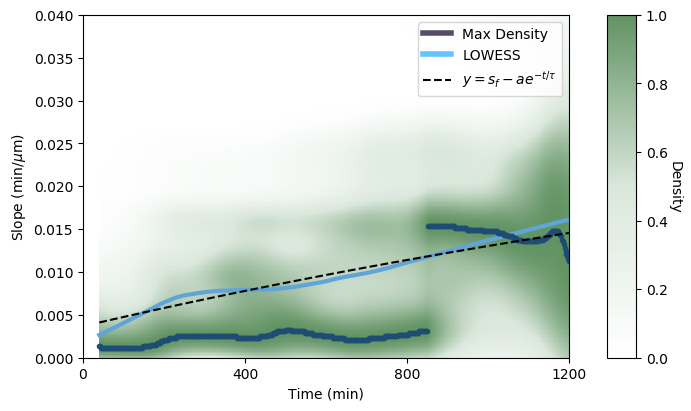

[0.0271305344257963, 280.3176913555107, 0.025124508666371524]
[8.80885410e-05 2.09419363e+00 4.63772798e-05]


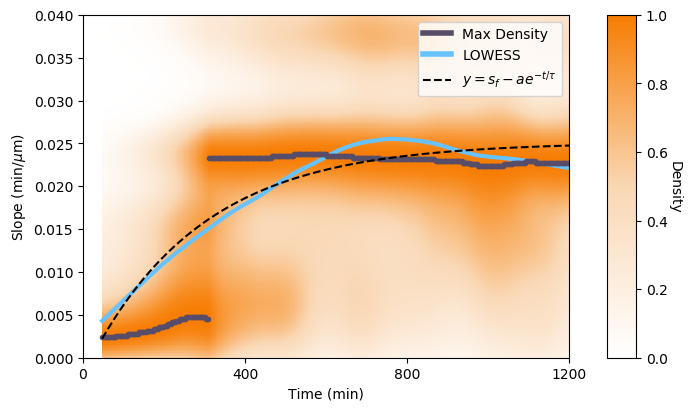

In [93]:
size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax1 = plt.gca()

cmap = custom_colormap(['#FFFFFF','#DAE7DB','#629364'])
im = ax1.pcolormesh(xx_S,yy_S,dens_S,cmap=cmap)

popt, pcov = curve_fit(lambda t, a, b, c: c - a * np.exp((-1)*(t)/ b), wnx_S, wny_S,bounds=(0, [0.1, 3000., 0.05]))
a = popt[0]
b = popt[1]
c = popt[2]
perr = np.sqrt(np.diag(pcov))
print([a,b,c])
print(perr)

x_fitted = np.linspace(np.min(wnx_S), np.max(wnx_S), 100)
y_fitted = c - a * np.exp((-1)* (x_fitted)/b)

ax1.plot(x_fitted,y_fitted,'k--',zorder=20)
ax1.plot(wnx_S,wny_S,c='#61A5D8',linewidth=3)
ax1.plot(xx_S,yy_S[np.argmax(dens_S,axis=0)],'.',c='#1D4D72')

cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_ylabel(r'Density', rotation=270, labelpad = 10)

ax1.set_xlim(0,np.percentile(dat_x_n_S,95))

ax1.set_xticks([0,400,800,1200])
ax1.set_xticklabels(['0','400','800','1200'])

ax1.set_ylim(0,0.04)
ax1.set_xlabel(r'Time (min)')
ax1.set_ylabel(r'Slope (min/$\mu$m)')
custom_lines = [Line2D([0], [0], color='#574D68', lw=4),
                Line2D([0], [0], color='#66C3FF', lw=4),                
                Line2D([0], [0], color='k',linestyle='--')]
ax1.legend(custom_lines, [r'Max Density',r'LOWESS',r'$y = s_f - a e^{-t / \tau}$'])

# fig.savefig('dani_figs/chem_kde_slope_density_plots_with_LOWESS_fits_noDens_new.png', bbox_inches='tight', dpi=600)
plt.show()


size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax1 = plt.gca()

cmap = custom_colormap(['#FFFFFF','#F9D7B4','#F77D03'])
im = ax1.pcolormesh(xx_n_S,yy_n_S,dens_n_S,cmap=cmap)

popt, pcov = curve_fit(lambda t, a, b, c: c - a * np.exp((-1)*(t)/ b), wnx_n_S, wny_n_S,bounds=(0, [0.1, 3000., 0.05]))
a = popt[0]
b = popt[1]
c = popt[2]
perr = np.sqrt(np.diag(pcov))
print([a,b,c])
print(perr)

x_fitted = np.linspace(np.min(wnx_n_S), np.max(wnx_n_S), 100)
y_fitted = c - a * np.exp((-1)* (x_fitted)/b)
ax1.plot(x_fitted,y_fitted,'k--',zorder=20)

ax1.plot(wnx_n_S,wny_n_S,c='#66C3FF',linewidth=3)
ax1.plot(xx_n_S,yy_n_S[np.argmax(dens_n_S,axis=0)],'.',c='#574D68')

cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_ylabel(r'Density', rotation=270, labelpad = 10)

ax1.set_xlim(0,np.percentile(dat_x_n_S,95))
ax1.set_xticks([0,400,800,1200])
ax1.set_xticklabels(['0','400','800','1200'])
ax1.set_ylim(0,0.04)
ax1.set_xlabel(r'Time (min)')
ax1.set_ylabel(r'Slope (min/$\mu$m)')
custom_lines = [Line2D([0], [0], color='#574D68', lw=4),
                Line2D([0], [0], color='#66C3FF', lw=4),                
                Line2D([0], [0], color='k',linestyle='--')]
ax1.legend(custom_lines, [r'Max Density',r'LOWESS',r'$y = s_f - a e^{-t / \tau}$'])
# fig.savefig('dani_figs/nuc_kde_slope_density_plots_with_LOWESS_fits_noDens.png', bbox_inches='tight', dpi=600)
plt.show()

#### Period

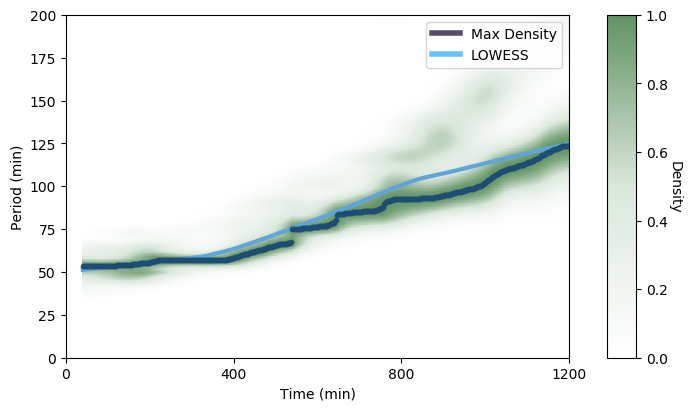

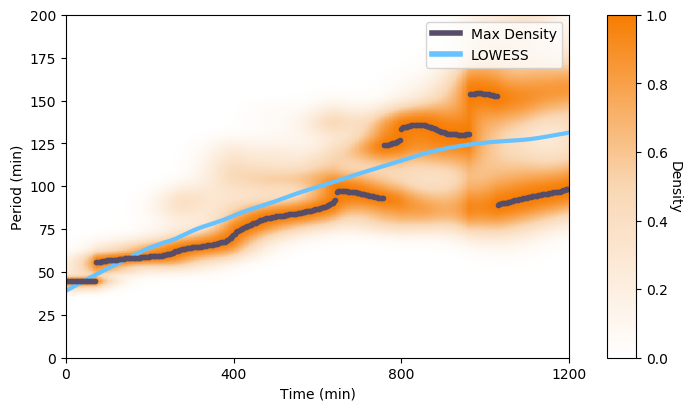

In [94]:
size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax1 = plt.gca()

cmap = custom_colormap(['#FFFFFF','#DAE7DB','#629364'])
im = ax1.pcolormesh(xx_T,yy_T,dens_T,cmap=cmap)

ax1.plot(wnx_T,wny_T,c='#61A5D8',linewidth=3)
ax1.plot(xx_T,yy_T[np.argmax(dens_T,axis=0)],'.',c='#1D4D72')

cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_ylabel(r'Density', rotation=270, labelpad = 10)
ax1.set_xlim(0,np.percentile(dat_x_n_S,95))

ax1.set_xticks([0,400,800,1200])
ax1.set_xticklabels(['0','400','800','1200'])

# ax0.set_xlim(-50,1300)
ax1.set_ylim(0,200.0)
ax1.set_xlabel(r'Time (min)')
ax1.set_ylabel(r'Period (min)')
custom_lines = [Line2D([0], [0], color='#574D68', lw=4),
                Line2D([0], [0], color='#66C3FF', lw=4)]
ax1.legend(custom_lines, [r'Max Density',r'LOWESS'])
# fig.savefig('dani_figs/chem_kde_period_density_plots_with_LOWESS_fits_noDens_new.png', bbox_inches='tight', dpi=600)
plt.show()


size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax1 = plt.gca()
cmap = custom_colormap(['#FFFFFF','#F9D7B4','#F77D03'])
im = ax1.pcolormesh(xx_n_T,yy_n_T,dens_n_T,cmap=cmap)

ax1.plot(wnx_n_T,wny_n_T,c='#66C3FF',linewidth=3)
ax1.plot(xx_n_T,yy_n_T[np.argmax(dens_n_T,axis=0)],'.',c='#574D68')

cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_ylabel(r'Density', rotation=270, labelpad = 10)

ax1.set_xlim(0,np.percentile(dat_x_n_S,95))
ax1.set_xticks([0,400,800,1200])
ax1.set_xticklabels(['0','400','800','1200'])
ax1.set_ylim(0,200.0)
ax1.set_xlabel(r'Time (min)')
ax1.set_ylabel(r'Period (min)')
custom_lines = [Line2D([0], [0], color='#574D68', lw=4),
                Line2D([0], [0], color='#66C3FF', lw=4)]
ax1.legend(custom_lines, [r'Max Density',r'LOWESS'])
# fig.savefig('dani_figs/nuc_kde_period_density_plots_with_LOWESS_fits_noDens.png', bbox_inches='tight', dpi=600)
plt.show()

#### Activation Rate

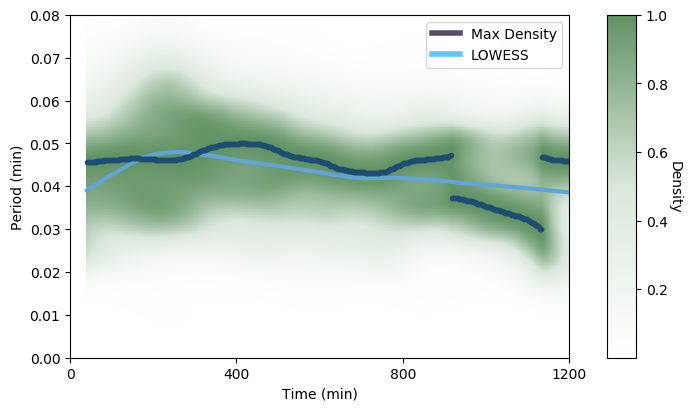

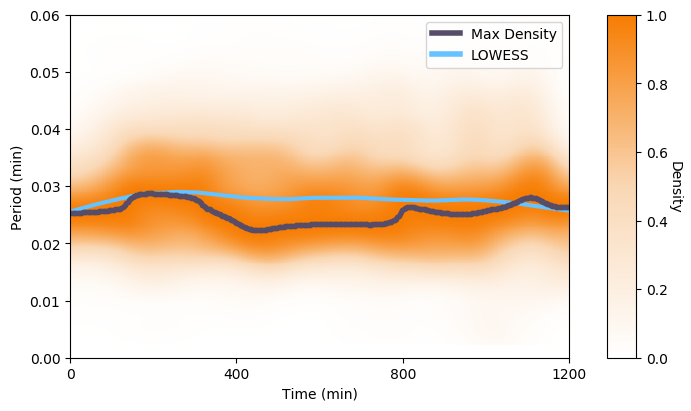

In [98]:
size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax1 = plt.gca()

cmap = custom_colormap(['#FFFFFF','#DAE7DB','#629364'])
im = ax1.pcolormesh(xx_A,yy_A,dens_A,cmap=cmap)

ax1.plot(wnx_A,wny_A,c='#61A5D8',linewidth=3)
ax1.plot(xx_A,yy_A[np.argmax(dens_A,axis=0)],'.',c='#1D4D72')

cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_ylabel(r'Density', rotation=270, labelpad = 10)
ax1.set_xlim(0,np.percentile(dat_x_n_S,95))

ax1.set_xticks([0,400,800,1200])
ax1.set_xticklabels(['0','400','800','1200'])

# ax0.set_xlim(-50,1300)
ax1.set_ylim(0,0.08)
ax1.set_xlabel(r'Time (min)')
ax1.set_ylabel(r'Period (min)')
custom_lines = [Line2D([0], [0], color='#574D68', lw=4),
                Line2D([0], [0], color='#66C3FF', lw=4)]
ax1.legend(custom_lines, [r'Max Density',r'LOWESS'])
# fig.savefig('dani_figs/chem_kde_period_density_plots_with_LOWESS_fits_noDens_new.png', bbox_inches='tight', dpi=600)
plt.show()


size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax1 = plt.gca()
cmap = custom_colormap(['#FFFFFF','#F9D7B4','#F77D03'])
im = ax1.pcolormesh(xx_n_A,yy_n_A,dens_n_A,cmap=cmap)

ax1.plot(wnx_n_A,wny_n_A,c='#66C3FF',linewidth=3)
ax1.plot(xx_n_A,yy_n_A[np.argmax(dens_n_A,axis=0)],'.',c='#574D68')

cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_ylabel(r'Density', rotation=270, labelpad = 10)

ax1.set_xlim(0,np.percentile(dat_x_n_S,95))
ax1.set_xticks([0,400,800,1200])
ax1.set_xticklabels(['0','400','800','1200'])
ax1.set_ylim(0,0.06)
ax1.set_xlabel(r'Time (min)')
ax1.set_ylabel(r'Period (min)')
custom_lines = [Line2D([0], [0], color='#574D68', lw=4),
                Line2D([0], [0], color='#66C3FF', lw=4)]
ax1.legend(custom_lines, [r'Max Density',r'LOWESS'])
# fig.savefig('dani_figs/nuc_kde_period_density_plots_with_LOWESS_fits_noDens.png', bbox_inches='tight', dpi=600)
plt.show()

### Dispersion Relations

#### Scatter + LOWESS

/home/owpuls/mitotic_waves/lib_mitotic_waves.py:516: RuntimeWarning: divide by zero encountered in true_divide
  speeds = np.gradient(el[1],1)/np.gradient(el[0],1)
/home/owpuls/mitotic_waves/lib_mitotic_waves.py:544: RuntimeWarning: invalid value encountered in subtract
  local_dev = arr - local_avg
/home/owpuls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


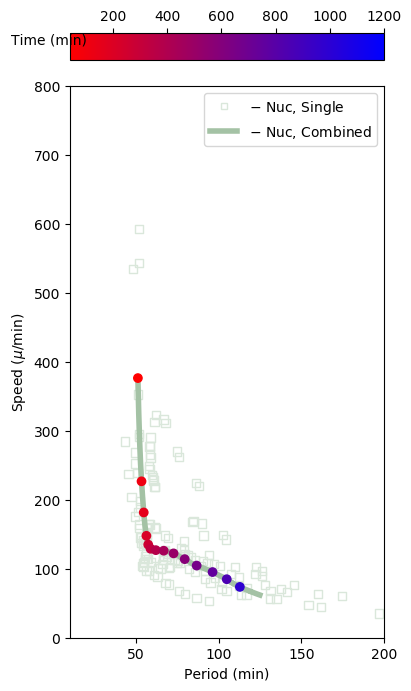

In [99]:
size = 4
fig = plt.figure(figsize=(size,1.7*size),constrained_layout=True)
ax = plt.gca()

cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["red","blue"])

dir_con_temp = get_sel_elements(dir_dd['temp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)'],
                           dir_dd['temp']['080421 (CSF_Cont)']['Pos1 (no nuc)'])

for item in dir_con_temp:

    dat_single = extract_data_v1(dir_con_temp[item])

    data_t_t = dat_single.copy()
    data_t_t = np.nan_to_num(data_t_t,nan=1e10)
    data_t_t = data_t_t[abs(data_t_t[:,3])<1e5]
    data_t_t = data_t_t[data_t_t[:,3]>1e-4]
    data_t_t = data_t_t[data_t_t[:,1] < 1500]
    data_t_t = data_t_t[data_t_t[:,2] > 0]
    data_t_t = data_t_t[data_t_t[:,5] < 0.1]
    mask = data_t_t[:,1] < 0
    data_t_t[mask] = 0
    data_t_t = data_t_t[data_t_t[:,1]>0]

    z_s = lowess(1/data_t_t[:,3], data_t_t[:,1], frac= 1./3, it=3,return_sorted=True)
    x_s = z_s[:,0]
    y_s = z_s[:,1]
    temp = x_s[-1]
    # norm=plt.Normalize(0,temp)

    z_T = lowess(data_t_t[:,2], data_t_t[:,1], frac= 1./3, it=3,return_sorted=True)
    x_T = z_T[:,0]
    y_T = z_T[:,1]

    ax.scatter(y_T[0:len(y_s):50], 1/y_s[0:-1:50], marker='s',edgecolor='#DAE7DB',facecolor='none',label=r'$+$ Nuclei',zorder=-10)

    ax.set_xlabel(r'Period (min)')
    ax.set_ylabel(r'Speed ($\mu$/min)')

size = 4

ax.plot(wny_T, 1/wny_S, c='#A4C2A5',label=r'$+$ Nuclei',zorder=1,lw=4)
norm = plt.Normalize(np.amin(wnx_S),np.amax(wnx_S))
im=ax.scatter(wny_T[0:-1:500],1/wny_S[0:-1:500],c=wnx_S[0:-1:500],cmap=cm1,edgecolors='face',label=r'$-$ Nuclei',norm=norm,zorder=10)

ax.set_xlim([10,200])
ax.set_ylim([0,800])
cbar=plt.colorbar(im,location='top')
cbar.set_clim(0.0,temp)
cbar.ax.set_ylabel(r'Time (min)', rotation=0, labelpad = 15)


custom_lines = [Line2D([], [], marker="s", markersize=5, linewidth=0, color='#DAE7DB',fillstyle='none'),
                Line2D([0], [0], color='#A4C2A5', lw=4)]

ax.legend(custom_lines, [r'$-$ Nuc, Single', r'$-$ Nuc, Combined'])

# fig.savefig('dani_figs/chem_dispersion_LOWESS_timecolored_eveguide_scatter_NEW!.svg', bbox_inches='tight', dpi=300)
plt.show()

#### LOWESS w/ and w/o Sperm

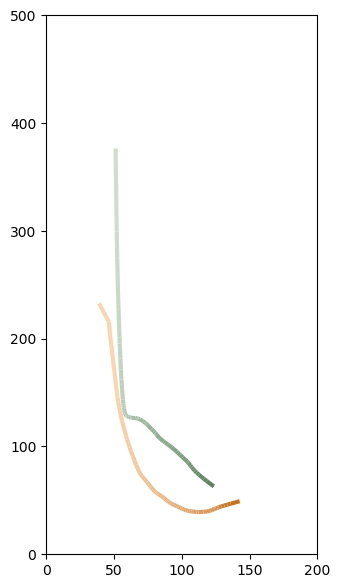

In [114]:
size = 7
fig, ax0 = plt.subplots(figsize=(0.5*size,size))

cols=[['#CEDECE','#527A52'],['#F9D6B3','#BE660E']]
cmap = custom_colormap_palette(cols[0])
plot_xyt_expt(ax0, wny_T, 1/wny_S, wnx_S, cols[0])

cmap = custom_colormap_palette(cols[1])
plot_xyt_expt(ax0, wny_n_T, 1/wny_n_S, wnx_n_S, cols[1])

ax0.set_xlim(0,200)
ax0.set_ylim(0,500)
ax0.set_xticks([0,50,100,150,200],['0','','100','','200'])
    
# fig.savefig('dani_figs/chem_dispersion_LOWESS_timecolored_NEW1.svg', bbox_inches='tight', dpi=300)
plt.show()

# Figure 2

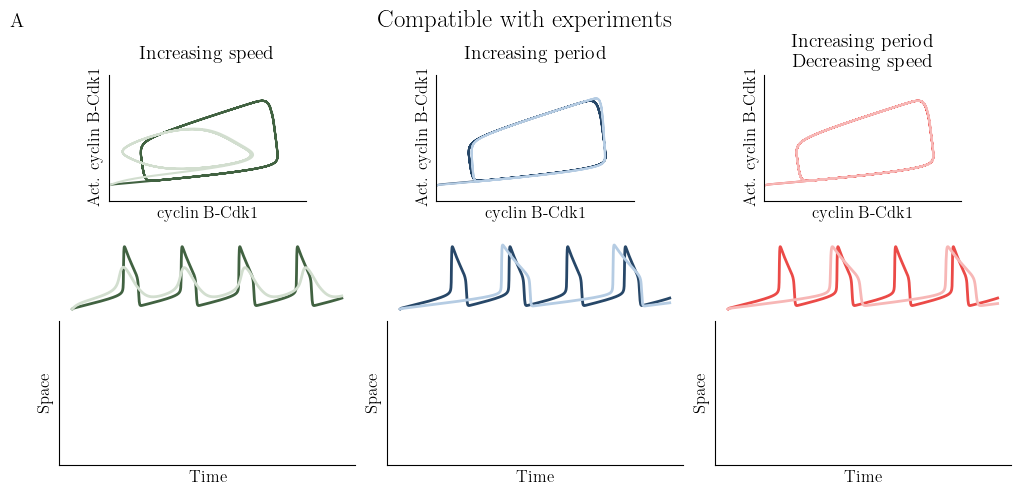

In [11]:
cols = [['#D2DECF','#6A966B','#416241'],
        ['#B5CCE3','#6796C5','#274768'],
        ['#F7B7B6','#EF6E6C','#EB4A47']]
cmap_0 = custom_colormap([cols[0][0],cols[0][2]])
cmap_1 = custom_colormap([cols[1][0],cols[1][2]])
cmap_2 = custom_colormap([cols[2][0],cols[2][2]])

in_0 = chang2013model(p_0) 
in_0.tf_timeseries = 150
in_0.nt_timeseries = 1000


plt.rcParams.update({'font.size': 12})
size = 8
fig = plt.figure(figsize=(1.6*size,2*size/3))#,constrained_layout=True)
nrow, ncol = 100,100
ax0 = plt.subplot2grid((nrow, ncol), (0, 5), rowspan = 31, colspan = 20)
ax1 = plt.subplot2grid((nrow, ncol), (0, 38), rowspan = 31, colspan = 20)
ax2 = plt.subplot2grid((nrow, ncol), (0, 71), rowspan = 31, colspan = 20)
ax3 = plt.subplot2grid((nrow, ncol), (60, 0), rowspan = 35, colspan = 30)
ax4 = plt.subplot2grid((nrow, ncol), (60, 33), rowspan = 35, colspan = 30)
ax5 = plt.subplot2grid((nrow, ncol), (60, 66), rowspan = 35, colspan = 30)
ax6 = plt.subplot2grid((nrow, ncol), (40, 0), rowspan = 20, colspan = 30)
ax7 = plt.subplot2grid((nrow, ncol), (40, 33), rowspan = 20, colspan = 30)
ax8 = plt.subplot2grid((nrow, ncol), (40, 66), rowspan = 20, colspan = 30)

tf, nt = 200,1000
in_1 = chang2013model(dict(p_0, alpha=1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax0,xlim=[40,80],ylim = [0,80],color = cols[0][2],axis=True)
plot_timeseries_fig2(in_1, ax6,color = cols[0][2])


in_1 = chang2013model(dict(p_0, alpha=.1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax0,xlim=[40,80],ylim = [0,80],color = cols[0][0],axis=True)
plot_timeseries_fig2(in_1, ax6,color = cols[0][0])

  
in_1 = chang2013model(dict(p_0, beta=1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax1,xlim=[40,80],ylim = [0,80],color = cols[1][2],axis=True)
plot_timeseries_fig2(in_1, ax7,color = cols[1][2])

in_1 = chang2013model(dict(p_0, beta=0.5))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax1,xlim=[40,80],ylim = [0,80],color = cols[1][0],axis=True)
plot_timeseries_fig2(in_1, ax7,color = cols[1][0])



in_1 = chang2013model(dict(p_0, tau=1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax2,xlim=[40,80],ylim = [0,80],color = cols[2][2],axis=True)
plot_timeseries_fig2(in_1, ax8,color = cols[2][2])

in_1 = chang2013model(dict(p_0, tau=0.5))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax2,xlim=[40,80],ylim = [0,80],color = cols[2][0],axis=True)
plot_timeseries_fig2(in_1, ax8,color = cols[2][0])


                     
ax3.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_xlabel('Time')
ax3.set_ylabel('Space')

ax4.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.set_xlabel('Time')
ax4.set_ylabel('Space')

ax5.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.set_xlabel('Time')
ax5.set_ylabel('Space')

ax0.text(20,110,'A',fontsize=14,color='black',weight='bold')
ax1.text(58,110,'Compatible with experiments',fontsize=18,color='black',weight='bold',horizontalalignment='center')
ax0.text(60,90,'Increasing speed',fontsize=14,color='black',weight='bold',horizontalalignment='center')
ax1.text(60,90,'Increasing period',fontsize=14,color='black',weight='bold',horizontalalignment='center')
ax2.text(60,85,'Increasing period \n Decreasing speed',fontsize=14,color='black',weight='bold',horizontalalignment='center')

plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/fig2av1.pdf',bbox_inches='tight',dpi=300)

plt.show()

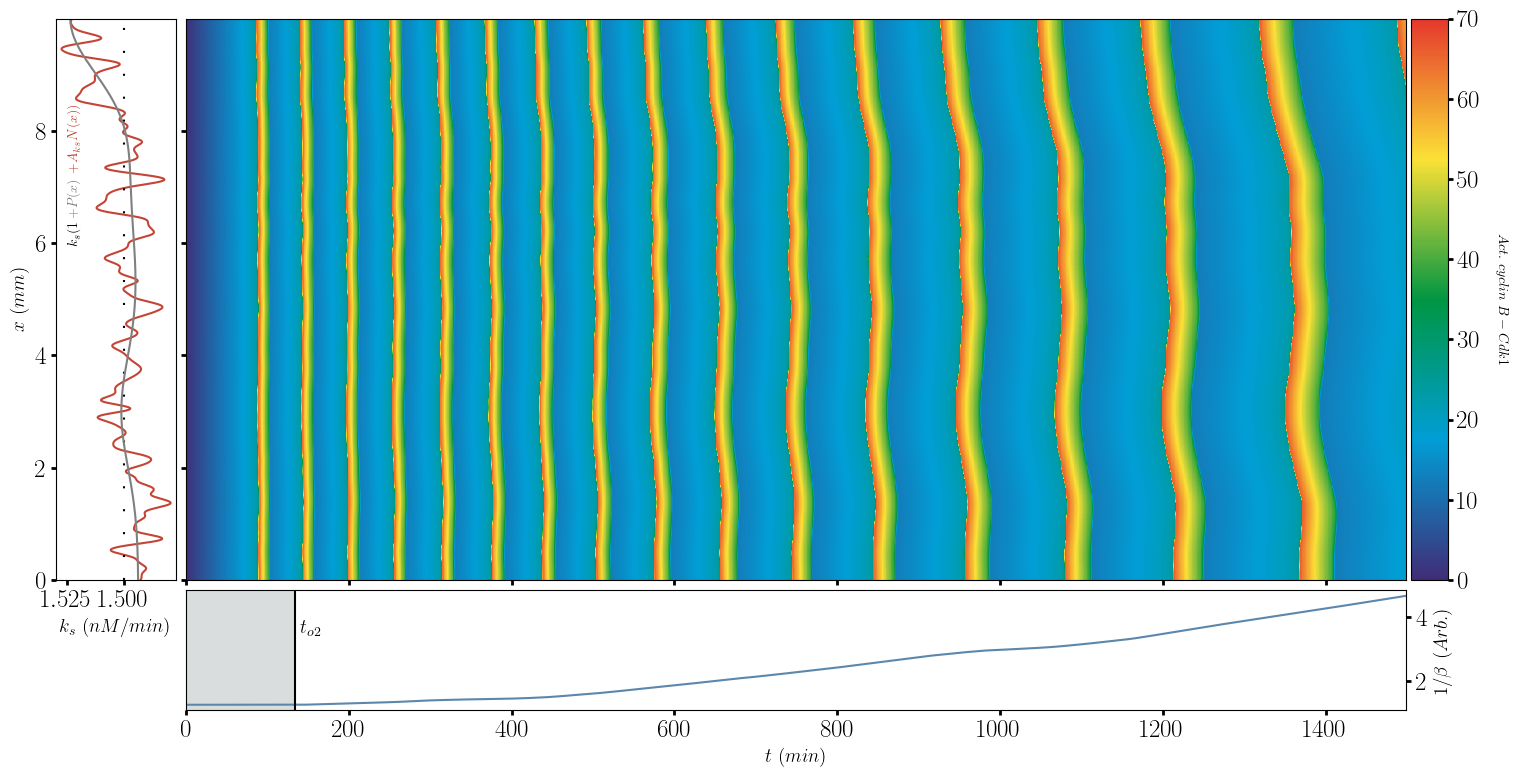

In [3]:
size = 7
fig = plt.figure(figsize=(2*size,size),constrained_layout=True)
ax = plt.subplot2grid((1, 1), (0, 0), colspan=60)

folder = '../sim/mit-waves12/'
plot_kymo_figure2(ax,folder,chi,133.5133513351335)
# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/fig2.1v3.pdf',bbox_inches='tight',dpi=300)

plt.show()

/home/druiz/Documents/cc/data-yang/github/lib_mitotic_waves.py:979: RuntimeWarning: divide by zero encountered in divide
  speeds = np.gradient(el[1],1)/np.gradient(el[0],1)
/home/druiz/Documents/cc/data-yang/github/lib_mitotic_waves.py:1007: RuntimeWarning: invalid value encountered in subtract
  local_dev = arr - local_avg


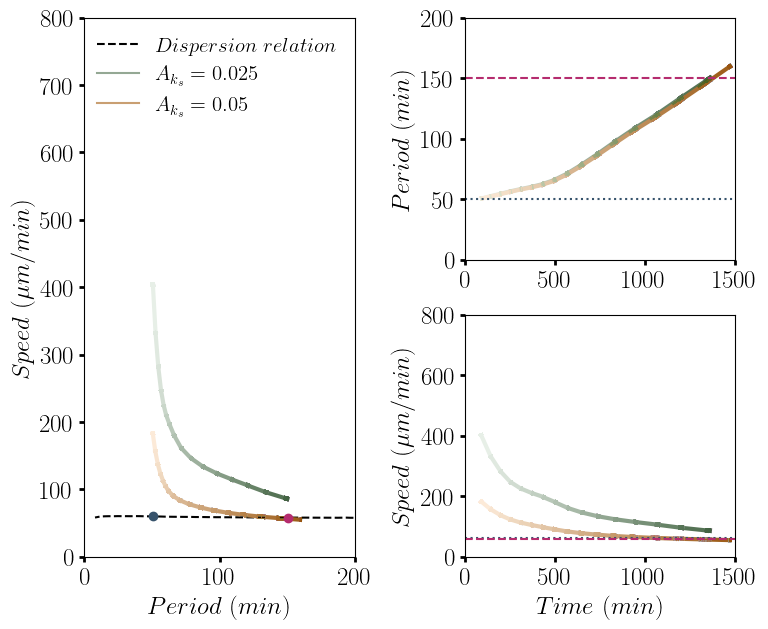

In [3]:
folder = '../sim/mit-waves17/'
x_p_real, y_p_real, x_s_real, y_s_real = get_dispersion_relation(folder,chi, plot=False)

folder = '../sim/mit-waves18/'
x_p_highaks, y_p_highaks, x_s_highaks, y_s_highaks = get_dispersion_relation(folder,chi, plot=False)

folder = '../sim/disp-rel/beta_scan/sim-85/'
x_p_85, y_p_85, x_s_85, y_s_85 = get_dispersion_relation(folder,chi, plot=False,resize = 512)

folder = '../sim/disp-rel/beta_scan/sim-53/'
x_p_53, y_p_53, x_s_53, y_s_53 = get_dispersion_relation(folder,chi, plot=False,resize = 512)


path_disp = '../sim/disp-rel/beta_scan/param_speed_period.npy'
lw = 3
# cols = ['#A4C2A5','#37526C','#6A90B4','#E086D3','#462749']
cols = [['#E7EFE7','#416241'],['#FCEBD9','#97540C'],['#E4EBF1','#37536C'],['#F7DEEA','#B52C6E'],['#F0E4F1','#66396A']]
line_labels = [r'$A_{k_s}=0.025$', r'$A_{k_s}=0.05$',r'$Low$ $period$',r'$High$ $period$',r'$Long$ $transient$',r'$Long$ $trans.,$ $high$ $A_{k_s}$']

size = 7
fig = plt.figure(figsize=(1.2*size,size))
ax0 = plt.subplot2grid((100, 120), (0, 0), colspan=50,rowspan=100)
ax1 = plt.subplot2grid((100, 120), (0, 70), colspan=50,rowspan=45)
ax2 = plt.subplot2grid((100, 120), (55, 70), colspan=50,rowspan=45)

labels = [r'$Time$ $(min)$',r'$Period$ $(min)$',r'$Speed$ $(\mu m/min)$']
ax0.set_xlabel(labels[1],fontsize=18)
ax0.set_ylabel(labels[2],fontsize=18)
ax1.set_ylabel(labels[1],fontsize=18)
ax2.set_ylabel(labels[2],fontsize=18)
ax2.set_xlabel(labels[0],fontsize=18)

with open(path_disp, 'rb') as f:
    param_scan = np.load(f)
    speeds = np.load(f)
    periods = np.load(f)
ax0.plot(periods[~np.isnan(speeds)],(abs(speeds[~np.isnan(speeds)])*chi*1e3),c='k',label=r'$Dispersion$ $relation$',linestyle='dashed')



handles, labels = ax0.get_legend_handles_labels()

cmap = custom_colormap(cols[0])
line0 = Line2D([0], [0], label=line_labels[0], color=cmap(0.5))
plot_xyt(ax0,ax1,ax2, y_p_real, 1/y_s_real, x_p_real, cols[0])

cmap = custom_colormap(cols[1])
line1 = Line2D([0], [0], label=line_labels[1], color=cmap(0.5))
plot_xyt(ax0,ax1,ax2, y_p_highaks, 1/y_s_highaks, x_p_highaks, cols[1])

# line2 = Line2D([0], [0], label=line_labels[2], color=cmap(0.5))
# plot_xyt(ax0,ax1,ax2, y_p_85, 1/y_s_85, x_p_85, cols[2])

# line3 = Line2D([0], [0], label=line_labels[3], color=cmap(0.5))
# plot_xyt(ax0,ax1,ax2, y_p_53, 1/y_s_53, x_p_53, cols[3])

ax0.plot(y_p_85[-1], 1/y_s_85[-1],'o',c=cols[2][-1])
ax1.axhline(y_p_85[-1],linestyle='dotted',c=cols[2][1])
ax2.axhline(1/y_s_85[-1],linestyle='dotted',c=cols[2][1])
ax0.plot(y_p_53[-1], 1/y_s_53[-1],'o',c=cols[3][-1])
ax1.axhline(y_p_53[-1],linestyle='dashed',c=cols[3][1])
ax2.axhline(1/y_s_53[-1],linestyle='dashed',c=cols[3][1])

# line4 = Line2D([0], [0], label=line_labels[4], color=cmap(0.5))
# plot_xyt(ax0,ax1,ax2, y_p_custom, 1/y_s_custom, x_p_custom, cols[4])

# ax0.plot(exp_data14['period'],exp_data14['speed'])
# ax1.plot(exp_data14['period_time'],exp_data14['period'])
# ax2.plot(exp_data14['speed_time'],exp_data14['speed'])

#add legend
handles.extend([line0, line1])
ax0.legend(frameon=False,fontsize=15,handles=handles)

# ax1.legend(frameon=False, fontsize=10)
# ax2.legend(frameon=False, fontsize=10)
# ax0.set_yscale('log')
# ax2.set_yscale('log')
ax0.set_xlim(0,200)
ax0.set_ylim(0,800)
ax1.set_xlim(0,1500)
ax1.set_ylim(0,200)
ax2.set_xlim(0,1500)
ax2.set_ylim(0,800)
# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/fig2.3v1.pdf',bbox_inches='tight',dpi=500)


plt.show()

### Experiment + Simulaiton Dispersion Relations

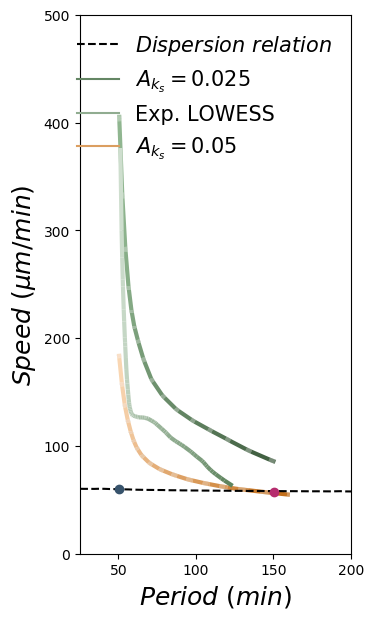

In [ ]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(102/256,87/256, N)
vals[:, 1] = np.linspace(195/256,77/256, N)
vals[:, 2] = np.linspace(255/256,104/256, N)
newcmp = ListedColormap(vals)
    

d_f2 = np.load('sim/data_fig2.npz')

lw = 3
cols = [['#90B690','#385638'],['#F9D6B3','#BE660E'],['#E4EBF1','#37536C'],['#F7DEEA','#B52C6E'],['#F0E4F1','#66396A']]
line_labels = [r'$A_{k_s}=0.025$', r'$A_{k_s}=0.05$',r'$Low$ $period$',r'$High$ $period$',r'$Long$ $transient$',r'$Long$ $trans.,$ $high$ $A_{k_s}$']

size = 7
fig, ax0 = plt.subplots(figsize=(0.5*size,size))

labels = [r'$Time$ $(min)$',r'$Period$ $(min)$',r'$Speed$ $(\mu m/min)$']
ax0.set_xlabel(labels[1],fontsize=18)
ax0.set_ylabel(labels[2],fontsize=18)

ax0.plot(d_f2['period_dr'],d_f2['speed_dr'],c='k',label=r'$Dispersion$ $relation$',linestyle='dashed')


handles, labels = ax0.get_legend_handles_labels()

cmap = custom_colormap_palette(cols[0])
line0 = Line2D([0], [0], label=line_labels[0], color=cmap(0.5))
plot_xyt(ax0,d_f2['period_aks_small'], d_f2['speed_aks_small'], d_f2['time_period_aks_small'], cols[0])

cmap = custom_colormap_palette(cols[1])
line1 = Line2D([0], [0], label=line_labels[1], color=cmap(0.5))
plot_xyt(ax0,d_f2['period_aks_high'], d_f2['speed_aks_high'], d_f2['time_period_aks_high'], cols[1])


ax0.plot(d_f2['period_high'], d_f2['speed_high'],'o',c=cols[2][-1])
ax0.plot(d_f2['period_small'], d_f2['speed_small'],'o',c=cols[3][-1])

ax0.set_xlim(25,200)
ax0.set_ylim(0,500)

cols=[['#CEDECE','#527A52']]

cmap = custom_colormap_palette(cols[0])
line2 = Line2D([0], [0], label='Exp. LOWESS', color=cmap(0.5))
plot_xyt(ax0, wny_T, 1/wny_S, wnx_S, cols[0])

#add legend
handles.extend([line0, line2, line1])
ax0.legend(frameon=False,fontsize=15,handles=handles)

# fig.savefig('dani_figs/chem_exp_sim_comp_dispersion_LOWESS_timecolored_NEW.svg', bbox_inches='tight', dpi=300)
plt.show()

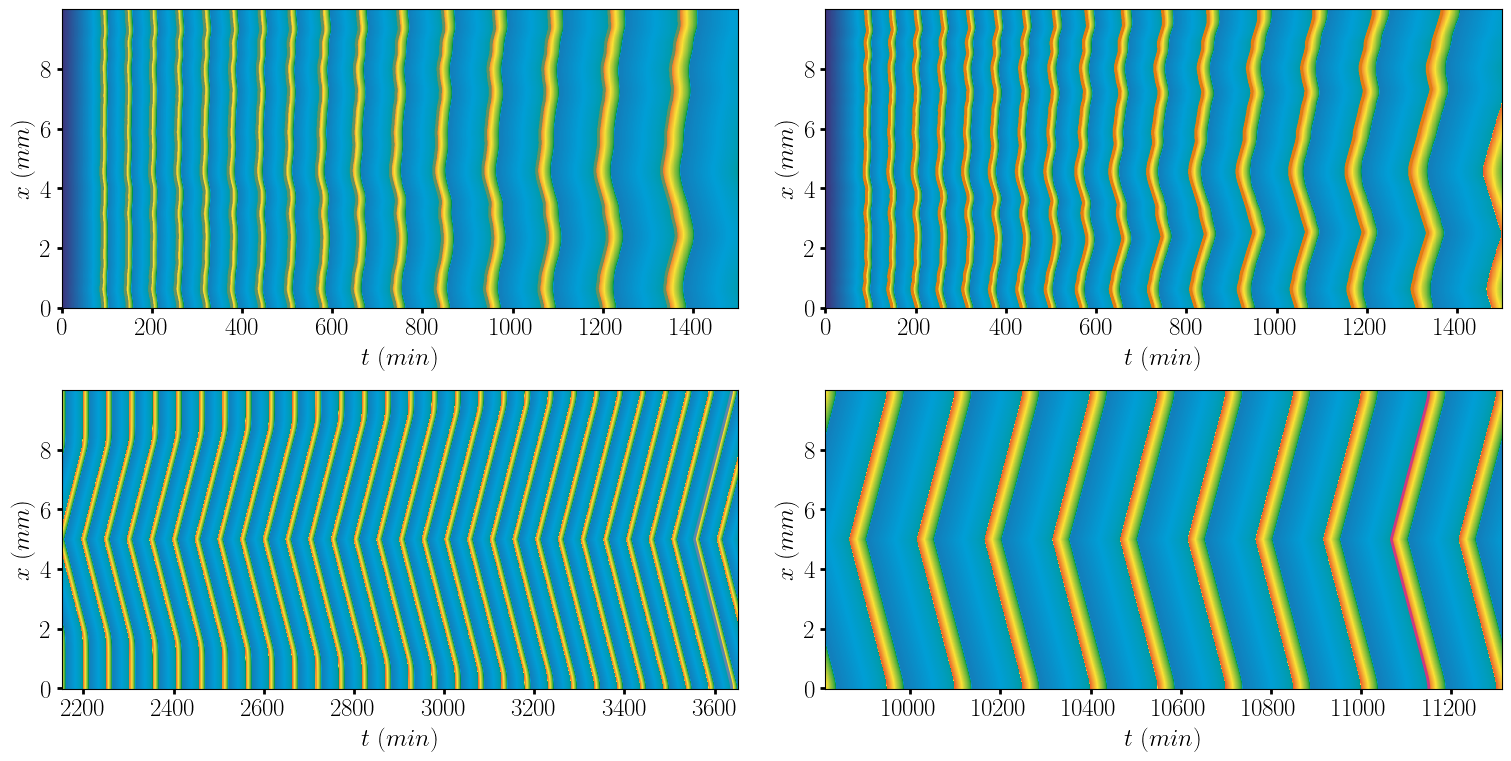

In [3]:
size = 5
fig = plt.figure(figsize=(2*1.5*size,1.5*size),constrained_layout=True)
ax = [None,None,None,None]
ax[0] = plt.subplot2grid((100, 100), (0, 0), rowspan=49, colspan=49)
ax[1] = plt.subplot2grid((100, 100), (0, 51), rowspan=49, colspan=49)
ax[2] = plt.subplot2grid((100, 100), (51, 0), rowspan=49, colspan=49)
ax[3] = plt.subplot2grid((100, 100), (51, 51), rowspan=49, colspan=49)
folders = ['../sim/mit-waves17/','../sim/mit-waves18/', '../sim/disp-rel/beta_scan/sim-85/', '../sim/disp-rel/beta_scan/sim-53/']
waves_id = ['All','All',-2,-2]  

cols =['#629362','#e27e12','#5c87ad','#cf3a82','#99569f']


for i,el in enumerate(folders):
    plot_simple_kymo(ax[i],el,chi,plot_traj = waves_id[i],color = cols[i] )
    
xmin, xmax = ax[2].get_xlim()
ax[2].set_xlim(xmax-1500,xmax)
xmin, xmax = ax[3].get_xlim()
ax[3].set_xlim(xmax-1500,xmax)
# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/fig2.2v2.pdf',bbox_inches='tight',dpi=500)

plt.show()

/tmp/ipykernel_2700009/1195045452.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('turbo')


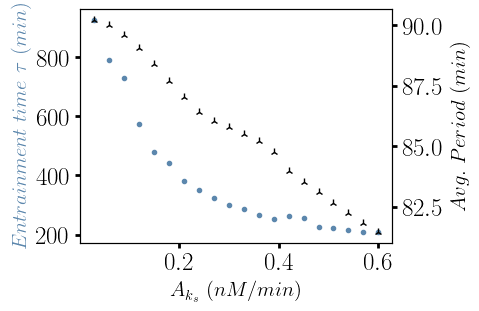

In [4]:
n_p = 20
n_rel = 10
array_fit_params = np.zeros((n_p,n_rel,8))
for k in range(n_p):
    for j in range(n_rel):
        folder = '../sim/ks-amp-scan1/p{}/r{}/'.format(k,j)
        try:
            with open(folder + 'fitparams.npy', 'rb') as f:
                array_fit_params[k,j] = np.load(f)
        except:
            print('p{}/r{}/'.format(k,j),end=' ')
            # print(folder)
            

size = 3
fig = plt.figure(figsize=(1.3*size*2,size),constrained_layout=True)
ax0 = plt.subplot2grid((1, 2), (0, 0))


afm = array_fit_params.copy()
cmap = plt.cm.get_cmap('turbo')
col = cmap(np.linspace(0.1,1,n_rel))
ax00 = ax0.twinx()

for k in range(n_p):
    ax00.plot(np.average(afm[k,:,0]),np.average(afm[k,:,4]),'2',c='k')
    ax0.plot(np.average(afm[k,:,0]),np.average(afm[k,:,2]),'.',c='#5C87AD')


ax0.set_xlabel(r'$A_{k_s}$ $(nM/min)$',fontsize=15)
ax0.set_ylabel(r'$Entrainment$ $time$ $\tau$ $(min)$',fontsize=15,color='#5C87AD')
ax00.set_ylabel(r'$Avg.$ $Period$ $(min)$',fontsize=15)


# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/fig2.4v2.pdf',bbox_inches='tight',dpi=500)
plt.show()

# Figure 4

## Single Kymograph (Interphase Extract)

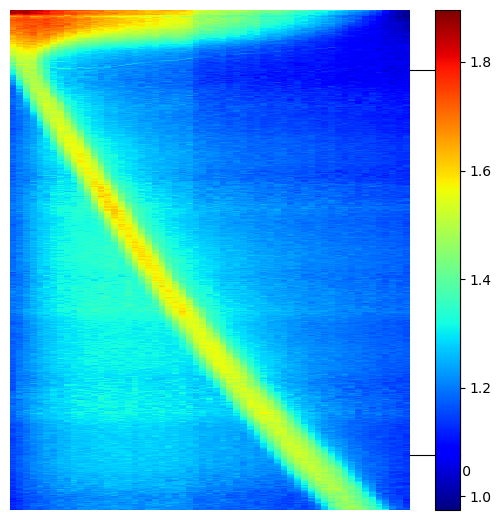

In [124]:
from matplotlib import colors
size = 5.0

# colormap = custom_colormap(['#E4EBF1','#5c87ad','#19354D'])

orig_image = io.imread('temp/112221_Pos5_Tube2_Ratio_New_Montage_TimeBinned.tif')
spc = 10.00

filled_cropped_image = orig_image
sz = np.shape(orig_image)

fig=plt.figure(figsize=(size,size))
ax = plt.gca()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
im=ax.pcolormesh(5.0*np.linspace(0,sz[1],sz[1]),spc*np.linspace(0,1,sz[0]),np.flipud(orig_image),cmap='jet')
cbar=plt.colorbar(im)

# plt.savefig('dani_figs/CSF_Int_singleTube_112221_Pos5Tube2_Ratio_Mongtage_Test.png',dpi=1200)
plt.show()



### Spatial Profiles

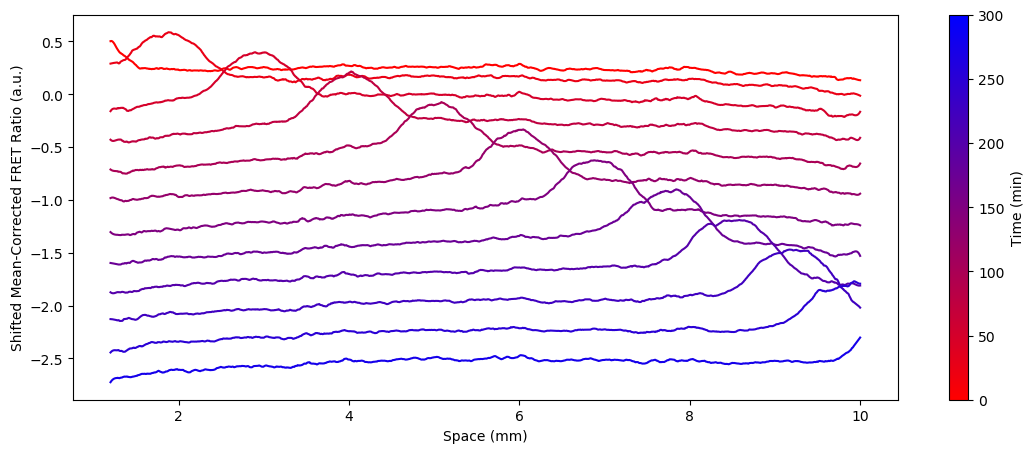

In [125]:
image = filled_cropped_image

size = 5
dt = 5
fig=plt.figure(figsize=(2.66*size,size))
strt = 0
end = 60
x1 = 200
x2 = image.shape[0]
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["red","blue"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=dt*strt,vmax=dt*end)

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
for j in range(strt,end,5):
  temp = signal.savgol_filter((image[x1:x2,j]),25,3)
  temp0 = image[x1:x2,strt:end]
  temp1 = (temp-np.min(temp0))/(np.max(temp0)-np.min(temp0))-(j - strt)*0.05
  plt.plot((spc/len(image[:,j]))*np.linspace(x1,x2,len(temp1)),temp1,color=cpick.to_rgba(dt*j))

plt.colorbar(cpick,fraction=0.15,label='Time (min)')
plt.xlabel('Space (mm)')
plt.ylabel('Shifted Mean-Corrected FRET Ratio (a.u.)')
# plt.savefig('dani_figs/chem_singleTube_Interphase'+str(strt)+'to'+str(end)+'_ShiftedProfiles.svg', format='svg',dpi=300)
plt.show()

## Single Kymographs (w/ and w/o nuclei)

### W/o Nuclei

In [138]:
def fill_nans(indata,sx,sy):
    indata[np.isinf(indata)]=np.nan
    new_indata = indata.copy()
    # Find the non-NaN indices
    
    ii,jj = np.where(np.isnan(indata))
    for i,j in zip(ii,jj):
        li0,li1 = max(0,i-sy//2), min(i+sy//2,indata.shape[0])
        lj0,lj1 = max(0,j-sx//2), min(j+sx//2,indata.shape[1])
        neighbours = indata[li0:li1,lj0:lj1]
        new_indata[i,j] = np.average(neighbours[~np.isnan(neighbours)])
        #indata[li0:li1,lj0:lj1] =100
        
    return new_indata

def extract_data_plt(ax,dir_el, xticks,flip=False,plot_crop=False,plot_traj=False,plot_cur=False,sigma=1,order=150):
    x,t,array,limits = dir_el['x'],dir_el['t'],dir_el['Activity'],dir_el['limits']
    x,t,array = crop(x,t,array,limits)
    if plot_crop:
        if flip:
            ax.pcolormesh(t,np.flipud(x),array,cmap='jet')
        else:
            ax.pcolormesh(t,x,array,cmap='jet')
    # clean_array = recursive_fill_nans(array,sx=10,sy=10)
    clean_array = fill_nans(array,sx=15,sy=15)
    clean_array1 = fill_nans(clean_array,sx=15,sy=15)
    array0 = detrend(clean_array1,axis=1)
    array = gaussian_filter(array0, sigma=sigma)   

    waves_traj = get_traj(t,x,array.T)
    new_waves_traj = reconstruct_waves(waves_traj)
    if plot_traj:
        for el in new_waves_traj:
            ax.plot(el[0],el[1],'.',markersize=2,c='66C3FF')
    
    #waves = poly_waves_traj(waves_traj,order=order)
    waves = spl_waves_traj(new_waves_traj,t[1]-t[0])
    if plot_cur:
        for el in waves:
            if flip:
                ax.plot(el[0],np.flipud(el[1]),c='w')
            else:
                ax.plot(el[0],el[1],c='w') 
    if plot_traj or plot_crop or plot_cur:
        ax.set_xlabel('Time (min)')
        ax.set_ylabel('Space (mm)')
        # ax.set_yticks([0,2000,4000,6000,8000,10000])
        ax.set_yticklabels(['0.0','2.0','4.0','6.0','8.0','10.0'])
        ax.set_xticks(xticks)
        ax.set_xticklabels(['0','500','1000','1500'])
        # plt.show()
    data_t = get_period_speed(waves,x,t,array0) 
    return data_t

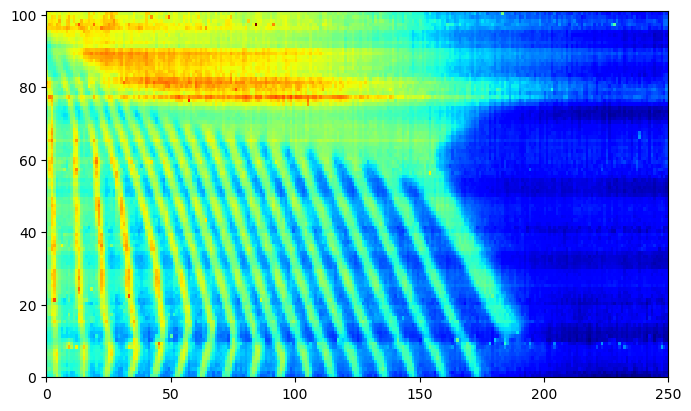

In [155]:
# dir_single = dir_dd['temp']['080421 (CSF)']['Pos2 (no nuc)']['Tube2Ratio_Montage.tif']
# dat_single = extract_data_v1(dir_single)
orig_image = io.imread('temp/080421 (CSF)/Pos2 (no nuc)/Tube2Ratio_Montage.tif')
filled_cropped_image = inpaint.inpaint_biharmonic(orig_image, np.isnan(orig_image))

size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax = plt.gca()
# dat_single = extract_data_plt(ax,dir_single,[0,400,800,1200],plot_crop=True,plot_traj=False,plot_cur=False)
ax.pcolormesh(np.flipud(filled_cropped_image),cmap='jet')
plt.show()

#### Spatial Profiles

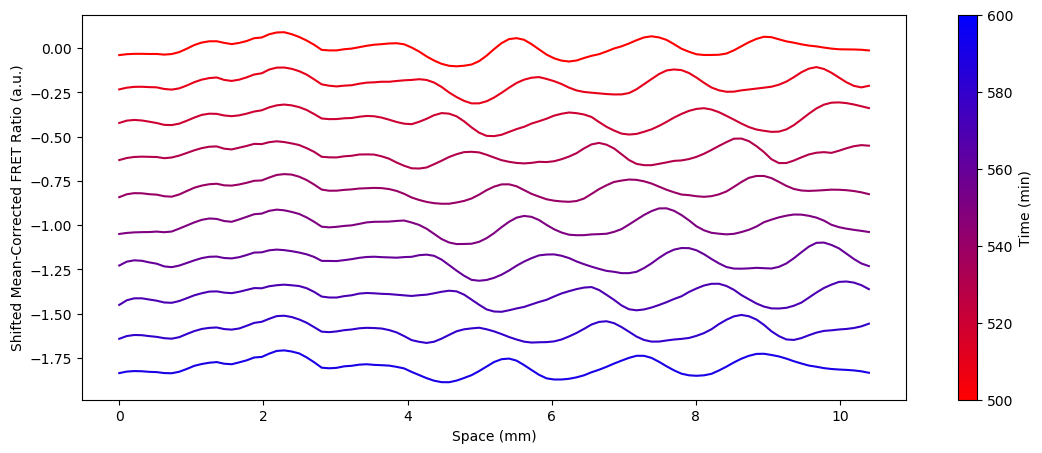

In [161]:
names = ['temp/080421 (CSF)/Pos2 (no nuc)/Tube2Ratio_Montage.tif']

orig_image = io.imread(names[0])
spc=10.4

size = 5
dt = 5
fig=plt.figure(figsize=(2.66*size,size))
strt = 100
end = 120
x1 = 0
x2 = image.shape[0]
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["red","blue"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=dt*strt,vmax=dt*end)

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
for j in range(strt,end,2):
  temp = signal.savgol_filter(np.flip(image[:,j]),9,3)
  temp2 = signal.detrend(temp)
  temp1 = temp2-np.mean(temp2) - (j - strt)*0.1
  plt.plot((spc/len(image[:,j]))*np.linspace(0,len(temp1),len(temp1)),np.flip(temp1),color=cpick.to_rgba(dt*j))

plt.colorbar(cpick,fraction=0.15,label='Time (min)')
plt.xlabel('Space (mm)')
plt.ylabel('Shifted Mean-Corrected FRET Ratio (a.u.)')
# plt.savefig('dani_figs/chem_singleTube_Cdc25_Tube4_Frame'+str(strt)+'to'+str(end)+'_ShiftedProfiles.svg', format='svg',dpi=300)
plt.show()

### W/ Nuclei

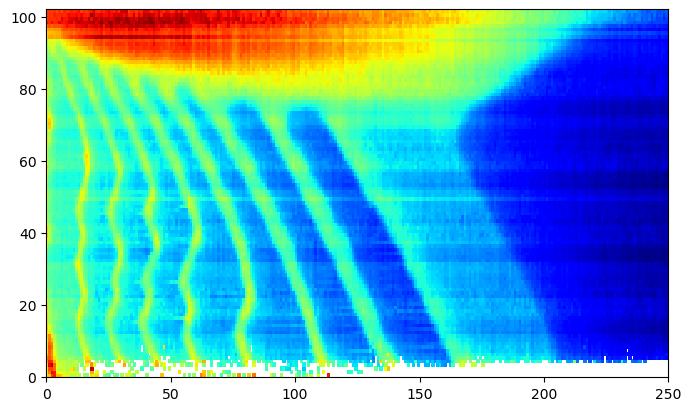

In [163]:
# dir_single = dir_dd['temp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif']
# dat_single = extract_data_v1(dir_single)
orig_image = io.imread('temp/080421 (CSF)/Pos6 (nuc)/Tube4Ratio_Montage.tif')
filled_cropped_image = inpaint.inpaint_biharmonic(orig_image, np.isnan(orig_image))

size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax = plt.gca()
# dat_single = extract_data_plt(ax,dir_single,[0,400,800,1200],plot_crop=True,plot_traj=False,plot_cur=False)
ax.pcolormesh(np.flipud(filled_cropped_image),cmap='jet')
plt.show()

#### Spatial Profiles

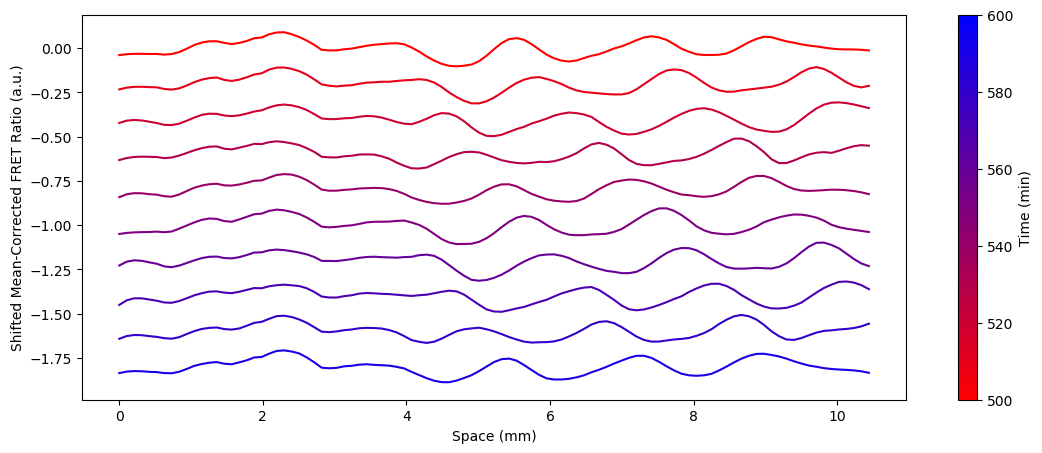

In [162]:
names = ['temp/080421 (CSF)/Pos6 (nuc)/Tube4Ratio_Montage.tif']

orig_image = io.imread(names[0])
spc=10.44

size = 5
dt = 5
fig=plt.figure(figsize=(2.66*size,size))
strt = 100
end = 120
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["red","blue"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=dt*strt,vmax=dt*end)

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])
for j in range(strt,end,2):
  temp = signal.savgol_filter(np.flip(image[:,j]),9,3)
  temp2 = signal.detrend(temp)
  temp1 = temp2-np.mean(temp2) - (j - strt)*0.1
  plt.plot((spc/len(image[:,j]))*np.linspace(0,len(temp1),len(temp1)),np.flip(temp1),color=cpick.to_rgba(dt*j))

plt.colorbar(cpick,fraction=0.15,label='Time (min)')
plt.xlabel('Space (mm)')
plt.ylabel('Shifted Mean-Corrected FRET Ratio (a.u.)')
# plt.savefig('dani_figs/chem_singleTube_Cdc25_Tube4_Frame'+str(strt)+'to'+str(end)+'_ShiftedProfiles.svg', format='svg',dpi=300)
plt.show()

## Load Cleaned Data

In [164]:
data_saved = np.load('expt_data_csf.npz')
dat_con = data_saved['dat_con_s']
dat_con_n = data_saved['dat_con_n_s']
data_t = data_saved['data_t_s']
data_t_n = data_saved['data_t_n_s']

## Compute LOWESS and KDE

In [165]:
### W/O Sperm DNA
# Slope LOWESS and KDE
dat_y = 1/abs(data_t[:,3])
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y_S = dat_y[dat_x<1200]
dat_x_S = dat_x[dat_x<1200]

smooth_coeff = 1./3
wnx_S,wny_S = sm.nonparametric.lowess(dat_y_S,dat_x_S,  frac=smooth_coeff, it=1, return_sorted = True).T


xx_S,yy_S,dens_S = custom_guassian_kde(dat_x_S,dat_y_S)

# Period LOWESS and KDE
dat_y = data_t[:,2]
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y_T = dat_y[dat_x<1200]
dat_x_T = dat_x[dat_x<1200]

smooth_coeff = 1./3
wnx_T,wny_T = sm.nonparametric.lowess(dat_y_T,dat_x_T,  frac=smooth_coeff, it=1, return_sorted = True).T

xx_T,yy_T,dens_T = custom_guassian_kde(dat_x_T,dat_y_T)

# Activation Rate LOWESS and KDE
dat_y = data_t[:,5]
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y_A = dat_y[dat_x<1200]
dat_x_A = dat_x[dat_x<1200]

smooth_coeff = 1./3
wnx_A,wny_A = sm.nonparametric.lowess(dat_y_A,dat_x_A,  frac=smooth_coeff, it=1, return_sorted = True).T

xx_A,yy_A,dens_A = custom_guassian_kde(dat_x_A,dat_y_A)

### W/ Sperm DNA
# Slope LOWESS and KDE
dat_y_n = 1/abs(data_t_n[:,3])
dat_x_n = data_t_n[:,1].copy()

dat_x_n = dat_x_n[~np.isnan(dat_y_n)]
dat_y_n = dat_y_n[~np.isnan(dat_y_n)]
dat_x_n = dat_x_n[~np.isinf(dat_y_n)]
dat_y_n = dat_y_n[~np.isinf(dat_y_n)]

dat_x_n = dat_x_n[dat_y_n<0.2]
dat_y_n = dat_y_n[dat_y_n<0.2]

dat_y_n_S = dat_y_n
dat_x_n_S = dat_x_n

smooth_coeff = 1./3
wnx_n_S,wny_n_S = sm.nonparametric.lowess(dat_y_n,dat_x_n,  frac=smooth_coeff, it=1, return_sorted = True).T

xx_n_S,yy_n_S,dens_n_S = custom_guassian_kde(dat_x_n,dat_y_n)

# Period LOWESS and KDE
dat_y = data_t_n[:,2]
dat_x = data_t_n[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y_n_T = dat_y
dat_x_n_T = dat_x

smooth_coeff = 1./3
wnx_n_T,wny_n_T = sm.nonparametric.lowess(dat_y_n_T,dat_x_n_T,  frac=smooth_coeff, it=1, return_sorted = True).T

xx_n_T,yy_n_T,dens_n_T = custom_guassian_kde(dat_x_n_T,dat_y_n_T)

# Activation Rate LOWESS and KDE
dat_y = data_t_n[:,5]
dat_x = data_t_n[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y_n_A = dat_y
dat_x_n_A = dat_x

smooth_coeff = 1./3
wnx_n_A,wny_n_A = sm.nonparametric.lowess(dat_y_n_A,dat_x_n_A,  frac=smooth_coeff, it=1, return_sorted = True).T

xx_n_A,yy_n_A,dens_n_A = custom_guassian_kde(dat_x_n_A,dat_y_n_A)

## Plot LOWESS and KDE

### Slope

[0.01707639666846357, 387.61382279279456, 0.032143304748587974, 170.52457879026227]
[6.28979911e-05 2.18785537e+00 5.90940164e-05 1.17591551e-08]


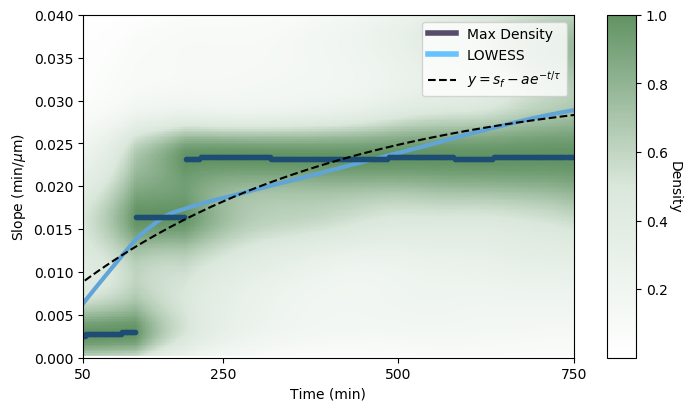

[0.014829421120554796, 163.3990216758043, 0.03437750584781408, 148.49365942152818]
[1.30697929e-05 2.21485390e-01 1.01374564e-05 1.35746008e-09]


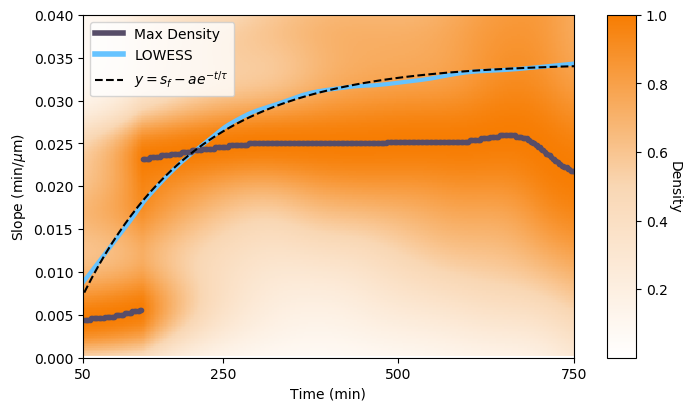

In [166]:
size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax1 = plt.gca()

cmap = custom_colormap(['#FFFFFF','#DAE7DB','#629364'])
im = ax1.pcolormesh(xx_S,yy_S,dens_S,cmap=cmap)

popt, pcov = curve_fit(lambda t, a, b, c,d: c - a * np.exp((-1)*(t-d)/ b), wnx_S, wny_S,bounds=(0, [0.1, 3000., 0.05,1000]))
a = popt[0]
b = popt[1]
c = popt[2]
d = popt[3]
perr = np.sqrt(np.diag(pcov))
print([a,b,c,d])
print(perr)

x_fitted = np.linspace(np.min(wnx_S), np.max(wnx_S), 100)
y_fitted = c - a * np.exp((-1)* (x_fitted - d)/b)

ax1.plot(x_fitted,y_fitted,'k--',zorder=20)
ax1.plot(wnx_S,wny_S,c='#61A5D8',linewidth=3)
ax1.plot(xx_S,yy_S[np.argmax(dens_S,axis=0)],'.',c='#1D4D72')

cbar = plt.colorbar(im, ax=ax1)

cbar.ax.set_ylabel(r'Density', rotation=270, labelpad = 10)

ax1.set_xlim(50,np.percentile(dat_x_n,95))

ax1.set_xticks([50,250,500,750])
ax1.set_xticklabels(['50','250','500','750'])

ax1.set_ylim(0,0.04)
ax1.set_xlabel(r'Time (min)')
ax1.set_ylabel(r'Slope (min/$\mu$m)')
custom_lines = [Line2D([0], [0], color='#574D68', lw=4),
                Line2D([0], [0], color='#66C3FF', lw=4),                
                Line2D([0], [0], color='k',linestyle='--')]
ax1.legend(custom_lines, [r'Max Density',r'LOWESS',r'$y = s_f - a e^{-t / \tau}$'])
# fig.savefig('dani_figs/CSF_chem_kde_slope_density_plots_with_LOWESS_fits_noDens.png', bbox_inches='tight', dpi=600)
plt.show()


size = 4
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax1 = plt.gca()
cmap = custom_colormap(['#FFFFFF','#F9D7B4','#F77D03'])
im = ax1.pcolormesh(xx_n_S,yy_n_S,dens_n_S,cmap=cmap)

popt, pcov = curve_fit(lambda t, a, b, c,d: c - a * np.exp((-1)*(t-d)/ b), wnx_n_S, wny_n_S,bounds=(0, [0.1, 3000., 0.05,1000]))
a = popt[0]
b = popt[1]
c = popt[2]
d = popt[3]
perr = np.sqrt(np.diag(pcov))
print([a,b,c,d])
print(perr)

x_fitted = np.linspace(np.min(wnx_n_S), np.max(wnx_n_S), 100)
y_fitted = c - a * np.exp((-1)* (x_fitted - d)/b)

ax1.plot(x_fitted,y_fitted,'k--',zorder=20)

ax1.plot(wnx_n_S,wny_n_S,c='#66C3FF',linewidth=3)
ax1.plot(xx_n_S,yy_n_S[np.argmax(dens_n_S,axis=0)],'.',c='#574D68')

cbar = plt.colorbar(im, ax=ax1)

cbar.ax.set_ylabel(r'Density', rotation=270, labelpad = 10)

ax1.set_xlim(50,np.percentile(dat_x_n,95))
ax1.set_xticks([50,250,500,750])
ax1.set_xticklabels(['50','250','500','750'])

ax1.set_ylim(0,0.04)
ax1.set_xlabel(r'Time (min)')
ax1.set_ylabel(r'Slope (min/$\mu$m)')
custom_lines = [Line2D([0], [0], color='#574D68', lw=4),
                Line2D([0], [0], color='#66C3FF', lw=4),                
                Line2D([0], [0], color='k',linestyle='--')]
ax1.legend(custom_lines, [r'Max Density',r'LOWESS',r'$y = s_f - a e^{-t / \tau}$'])

# fig.savefig('dani_figs/CSF_nuc_kde_slope_density_plots_with_LOWESS_fits_noDens.png', bbox_inches='tight', dpi=600)
plt.show()

## Dispersion Relation

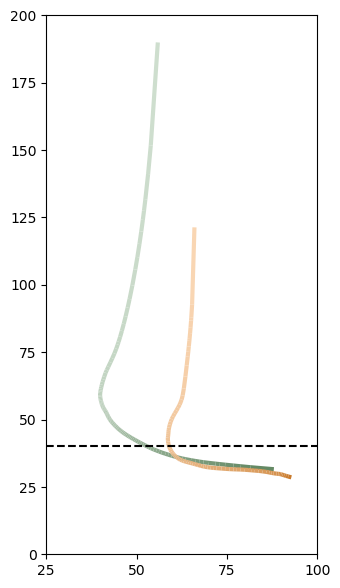

In [167]:

size = 7
fig, ax0 = plt.subplots(figsize=(0.5*size,size))

cols=[['#CEDECE','#527A52'],['#F9D6B3','#BE660E']]
cmap = custom_colormap_palette(cols[0])
plot_xyt_expt(ax0,wny_T, 1/wny_S, wnx_S, cols[0])

cmap = custom_colormap_palette(cols[1])
plot_xyt(ax0,wny_n_T, 1/wny_n_S, wnx_n_S, cols[1])
ax0.plot(np.linspace(25,100,10),np.ones(10)*40.0,'k--')

ax0.set_xlim(25,100)
ax0.set_ylim(0,200)

ax0.set_xticks([25,50,75,100])
    
# fig.savefig('dani_figs/CSF_chem_nuc_comp_dispersion_LOWESS_timecolored_NEW1.svg', bbox_inches='tight', dpi=300)
plt.show()

# Figure 5

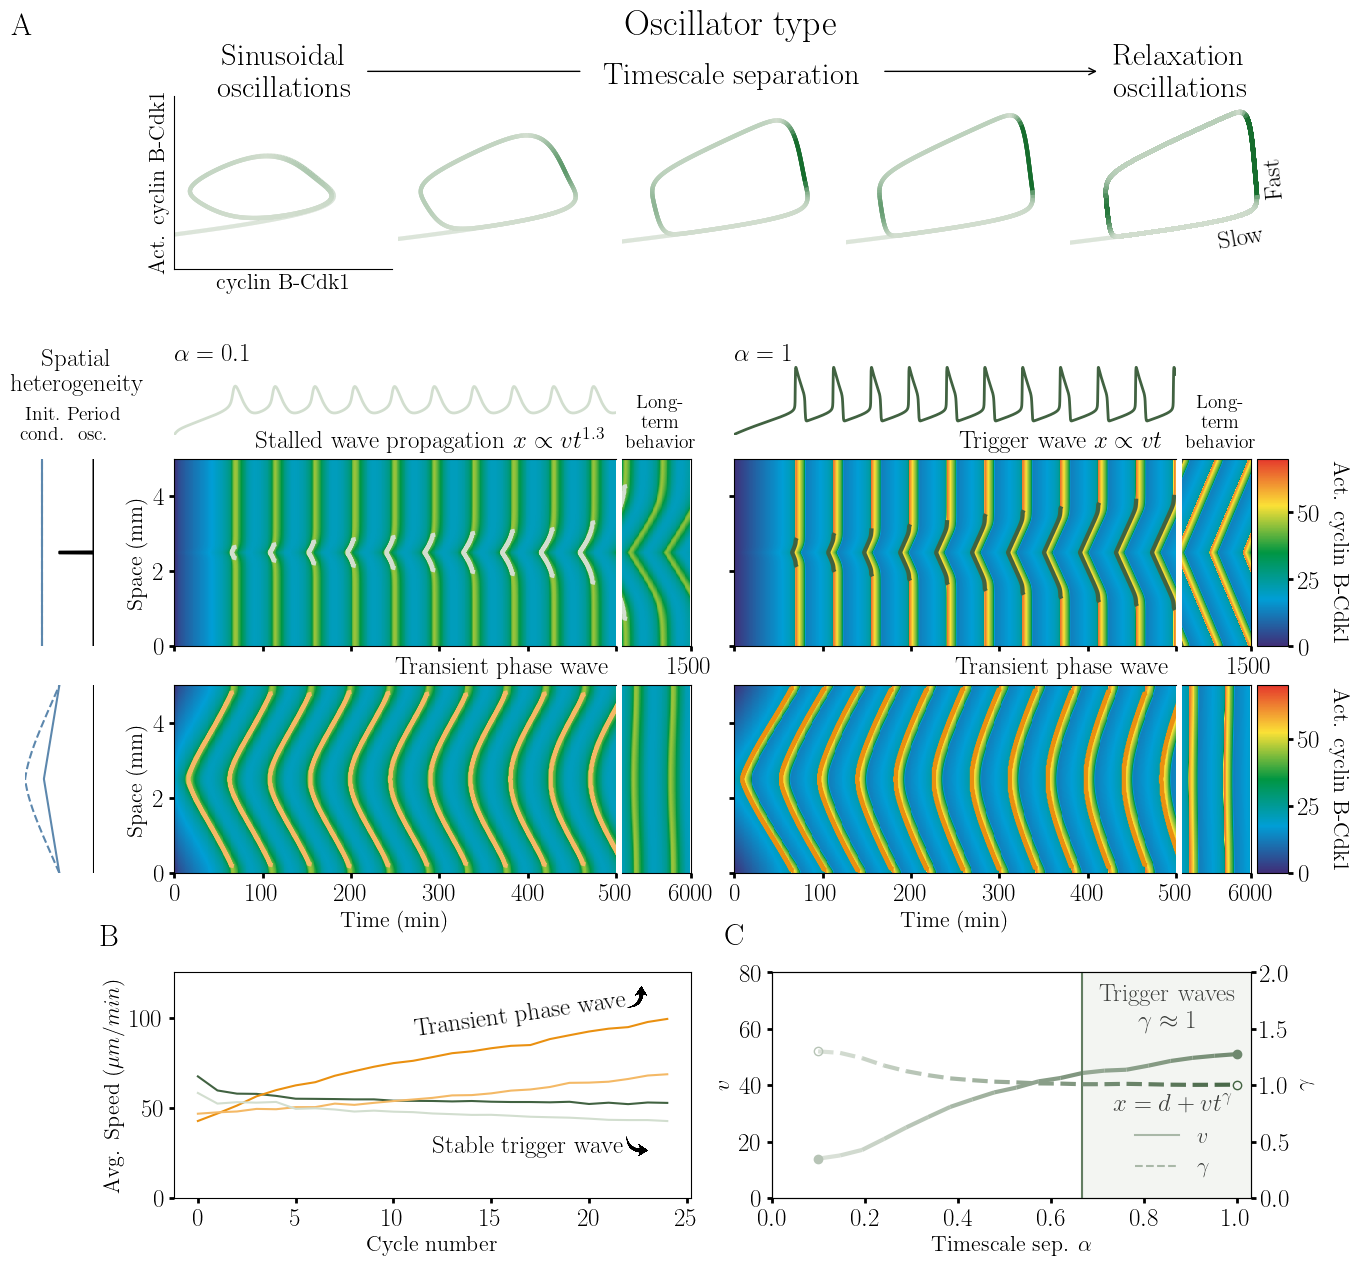

In [14]:
size = 15
nrows = 184
fig = plt.figure(figsize=(1.6*size,size*nrows/153))#,constrained_layout=True)
ax0   = plt.subplot2grid((nrows, 50), (00, 4), rowspan = 23, colspan = 6) # phase space
ax01  = plt.subplot2grid((nrows, 50), (00, 10), rowspan = 23, colspan = 6) # phase space
ax02  = plt.subplot2grid((nrows, 50), (00, 16), rowspan = 23, colspan = 6) # phase space
ax03  = plt.subplot2grid((nrows, 50), (00, 22), rowspan = 23, colspan = 6) # phase space
ax04  = plt.subplot2grid((nrows, 50), (00, 28), rowspan = 23, colspan = 6) # phase space

# ax10  = plt.subplot2grid((nrows, 50), (146, 10), rowspan = 30, colspan = 17) # alpha scan
ax10  = plt.subplot2grid((nrows, 50), (116, 20), rowspan = 30, colspan = 13) # alpha scan

# ax11  = plt.subplot2grid((157, 50), (100, 7), rowspan = 28, colspan = 28)

ax200 = plt.subplot2grid((nrows, 50), (35, 4), rowspan = 10, colspan = 12) #Time series
ax201 = plt.subplot2grid((nrows, 50), (35, 19), rowspan = 10, colspan = 12) #Time series

ax210 = plt.subplot2grid((nrows, 50), (48, 4), rowspan = 25, colspan = 12) #kymo up-left
ax211 = plt.subplot2grid((nrows, 50), (48, 19), rowspan = 25, colspan = 12) #kymo up-right
ax212 = plt.subplot2grid((nrows, 50), (48, 0), rowspan = 25, colspan = 2) #IC and tau up
cax1  = plt.subplot2grid((nrows, 50), (48, 33), rowspan = 25, colspan = 1) #Colorbar up
ax213 = plt.subplot2grid((nrows, 50), (48, 16), rowspan = 25, colspan = 2) #kymo up-left
ax214 = plt.subplot2grid((nrows, 50), (48, 31), rowspan = 25, colspan = 2) #kymo up-right

ax220 = plt.subplot2grid((nrows, 50), (78, 4), rowspan = 25, colspan = 12) #kymo down-left
ax221 = plt.subplot2grid((nrows, 50), (78, 19), rowspan = 25, colspan = 12) #kymo down-right
ax222 = plt.subplot2grid((nrows, 50), (78, 0), rowspan = 25, colspan = 2) #IC and tau down
cax2  = plt.subplot2grid((nrows, 50), (78, 33), rowspan = 25, colspan = 1) #Colorbar down
ax223 = plt.subplot2grid((nrows, 50), (78, 16), rowspan = 25, colspan = 2) #kymo up-left
ax224 = plt.subplot2grid((nrows, 50), (78, 31), rowspan = 25, colspan = 2) #kymo up-right

# ax230 = plt.subplot2grid((nrows, 50), (109, 4), rowspan = 25, colspan = 14) # Time evolution left
ax231 = plt.subplot2grid((nrows, 50), (116, 4), rowspan = 30, colspan = 14) # Time evolution right

cols = ['#416241','#e27e12','#EA9010','#D2DECF','#E9EEE7','#F4B966']
# cols = ['#416241','#e27e12','#4357AD','#D2DECF','#E9EEE7','#98A4D7']
# cols = ['#416241','#e27e12','#5E46AF','#D2DECF','#E9EEE7','#CC59D2']



folder = '../sim/scan-phase-trigger/icpeak/'
alphas = np.linspace(0.1,1,20)
ax10y = ax10.twinx()
plot_alphascan(ax10,ax10y,folder,chi,alphas,colors= [cols[4],cols[0]])

folders = ['../sim/scan-phase-trigger/icpeak-better-dt-phaseplane/sim-{}/'.format(i) for i in [0,2,7,12,19]]
axis_list = [True,False,False,False,False]
axi = [ax0,ax01,ax02,ax03,ax04]
cmap = custom_colormap([cols[3],cols[0]]) 
greens = cmap(np.linspace(0,1,5))
bars = [False,False,False,False,False]
for el, el1, el2, col, b in zip(folders,axi,axis_list,greens,bars):
    plot_phaseplane_color_timescale_sep(el1,el,color=col,axis = el2,plot_cbar=b)

i=19
folder = '../sim/scan-phase-trigger/icpeak/sim-{}/'.format(i)
folder1 = '../sim/scan-phase-trigger/icpeak-better-dt-phaseplane/sim-{}/'.format(i)

plot_evol_speed(ax231,folder,chi,color=cols[0],plot_yaxis=True)
plot_timeseries_fig5(ax201,folder1,color=cols[0])
plot_kymo_fig5_1(ax211,ax212,ax214,cax1,folder1,chi,plot_xaxis=False,plot_yaxis=False,plot_waves=True,plot_ictau=False,plot_ic=False,color=cols[0],tlim=1500)
folder = '../sim/scan-phase-trigger/ictriangle-long/sim-{}/'.format(i)
plot_evol_speed(ax231,folder,chi,color=cols[2],plot_yaxis=True)
plot_kymo_fig5_1(ax221,ax222,ax224,cax2,folder,chi,plot_xaxis=True,plot_yaxis=False,plot_waves=True,plot_ictau=False,plot_ic=False,color=cols[2],tlim=6000)

i=0
folder = '../sim/scan-phase-trigger/icpeak/sim-{}/'.format(i)

plot_timeseries_fig5(ax200,folder,color=cols[3])
plot_kymo_fig5_1(ax210,ax212,ax213,cax1,folder,chi,plot_ictau=True,plot_ic=True,plot_cbar=False,plot_xaxis=False,plot_waves=True,color=cols[3],tlim=1500)
folder = '../sim/scan-phase-trigger/ictriangle-long/sim-{}/'.format(i)
plot_evol_speed(ax231,folder,chi,color=cols[5])
plot_kymo_fig5_1(ax220,ax222,ax223,cax2,folder,chi,plot_ictau=True,plot_ic=True,plot_cbar=False,plot_xaxis=True,plot_waves=True,color=cols[5],tlim=6000)
folder = '../sim/scan-phase-trigger/icpeak/sim-{}/'.format(i)
plot_evol_speed(ax231,folder,chi,color=cols[3])

ax04.text(67,8,r'Slow',fontsize=18,color='black',weight='bold',rotation = 10)
ax04.text(75,30,r'Fast',fontsize=18,color='black',weight='bold',rotation = 95)
ax0.text(10,95,r'A',fontsize=22,color='black',weight='bold')
ax0.text(60,70,'Sinusoidal \n oscillations',fontsize=22,color='black',weight='bold',horizontalalignment='center')
ax02.text(60,95,r'Oscillator type',fontsize=26,color='black',weight='bold',horizontalalignment='center')
ax02.text(60,75,r'Timescale separation',fontsize=22,color='black',weight='bold',horizontalalignment='center')
ax04.text(60,70,'Relaxation \n oscillations',fontsize=22,color='black',weight='bold',horizontalalignment='center')


ax0.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

# ax10.text(0.58,78,r'$Trigger$ $wave$ $regime$',fontsize=18,color='black',weight='bold')
# ax10.text(0.4,88,r'$Phase$ $wave$ $regime$',fontsize=18,color='black',weight='bold')

ax231.text(-5,140,r'B',fontsize=22,color='black',weight='bold')
ax231.text(12,25,r'Stable trigger wave',fontsize=18,color='black',weight='bold')
ax231.text(11,90,r'Transient phase wave',fontsize=18,color='black',weight='bold',rotation =8)
# ax230.text(14,25,r'Stable trigger wave',fontsize=18,color='black',weight='bold')
# ax230.text(13,64,r'Transient phase wave',fontsize=18,color='black',weight='bold',rotation =6)

# ax212.text(1,0.5,r'$\tau(x)$',rotation='vertical',fontsize=18)
# ax222.text(1.2,0.5,r'$\tau(x)$',rotation='vertical',fontsize=18)
# ax222.text(1,0.5,r'IC',rotation='vertical',fontsize=18,color='#5C87AD')
ax200.text(0,70,r'$\alpha=0.1$',fontsize=18)
ax201.text(0,70,r'$\alpha=1$',fontsize=18)

ax210.text(550,5.3,'Long- \n term \n behavior',fontsize=14,horizontalalignment='center')
ax211.text(550,5.3,'Long- \n term \n behavior',fontsize=14,horizontalalignment='center')
ax210.text(290,5.3,'Stalled wave propagation $x \propto vt^{1.3}$ ',fontsize=18,horizontalalignment='center')
ax211.text(370,5.3,'Trigger wave $x \propto vt$',fontsize=18,horizontalalignment='center')
ax220.text(370,5.3,'Transient phase wave',fontsize=18,horizontalalignment='center')
ax221.text(370,5.3,'Transient phase wave',fontsize=18,horizontalalignment='center')


ax212.text(0.5,6.8,'Spatial \n heterogeneity',fontsize=18,horizontalalignment='center')
ax212.text(0,5.5,'Period \n osc.',fontsize = 14, horizontalalignment='center')
ax212.text(1.5,5.5,'Init. \n cond.',fontsize = 14, horizontalalignment='center')

ax10.text(-0.1,90,r'C',fontsize=22,color='black',weight='bold')
ax10.text(0.85,70,'Trigger waves',fontsize=18,color='black',weight='bold',horizontalalignment='center')
ax10.text(0.85,60,r'$\gamma \approx 1$',fontsize=18,color='black',weight='bold',horizontalalignment='center')
ax0.annotate("",xy=(115, 80), xycoords='data',xytext=(75, 80), textcoords='data',arrowprops=dict(arrowstyle="-"), annotation_clip=False)
ax0.annotate("",xy=(210, 80), xycoords='data',xytext=(170, 80), textcoords='data',arrowprops=dict(arrowstyle="->"), annotation_clip=False)

paths = [
    '../prolit/figs/up.png',
    '../prolit/figs/down.png']
    
x = [22.5,22.5]
y = [112,28]
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path, zoom=0.07), (x0, y0), frameon=False)
    ax231.add_artist(ab)

# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/fig5v7.pdf',bbox_inches='tight',dpi=300)
plt.show()

# Figure S1

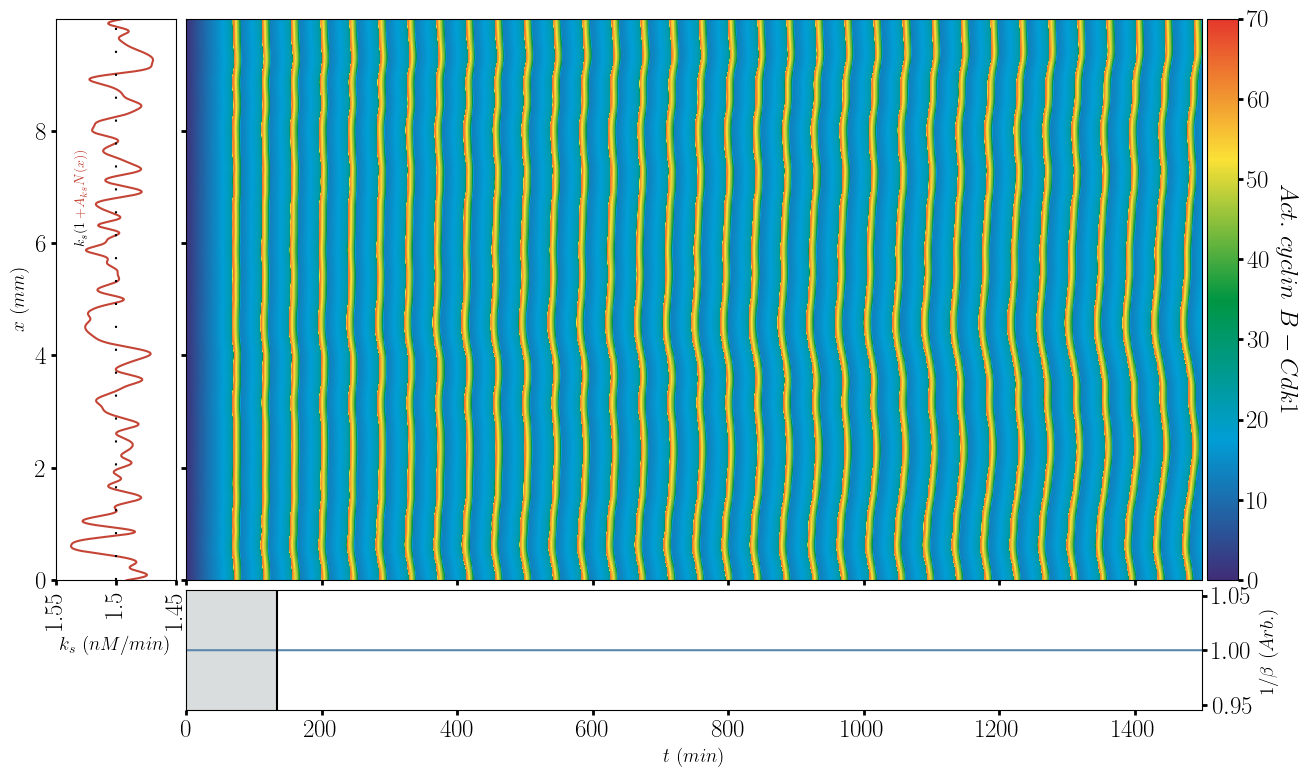

In [3]:
size = 7
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax = plt.subplot2grid((1, 1), (0, 0), colspan=60)

folder = '../sim/mit-waves31/'
plot_kymo_figure_s1(ax,folder,chi,133.5133513351335)
# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/figs1av0.pdf',bbox_inches='tight',dpi=300)

plt.show()

/home/druiz/Documents/cc/data-yang/github/lib_mitotic_waves.py:979: RuntimeWarning: divide by zero encountered in divide
  speeds = np.gradient(el[1],1)/np.gradient(el[0],1)
/home/druiz/Documents/cc/data-yang/github/lib_mitotic_waves.py:1007: RuntimeWarning: invalid value encountered in subtract
  local_dev = arr - local_avg


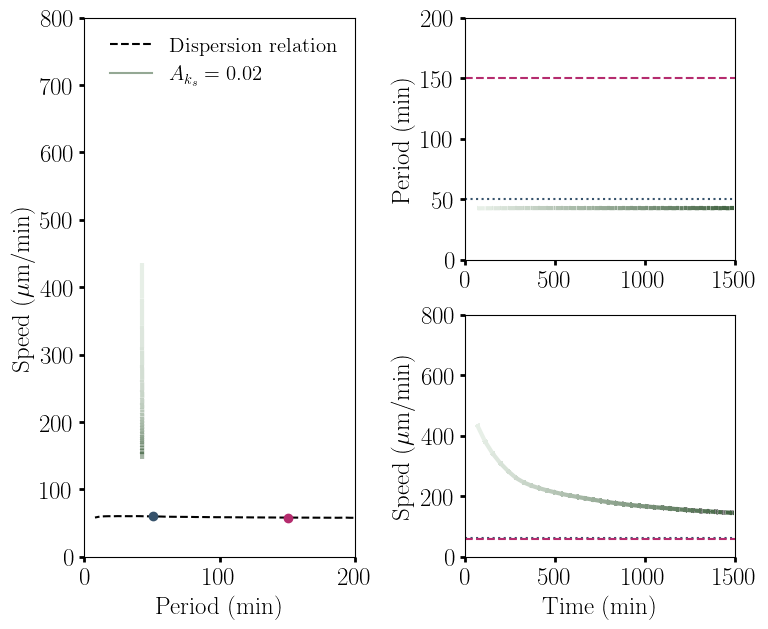

In [3]:
path_disp = '../sim/disp-rel/beta_scan/param_speed_period.npy'
lw = 3
# cols = ['#A4C2A5','#37526C','#6A90B4','#E086D3','#462749']
cols = [['#E7EFE7','#416241'],['#FCEBD9','#97540C'],['#E4EBF1','#37536C'],['#F7DEEA','#B52C6E'],['#F0E4F1','#66396A']]
line_labels = [r'$A_{k_s}=0.02$', r'$A_{k_s}=0.05$',r'Low period',r'High period',r'Long transient',r'Long trans., high $A_{k_s}$']

size = 7
fig = plt.figure(figsize=(1.2*size,size))
ax0 = plt.subplot2grid((100, 120), (0, 0), colspan=50,rowspan=100)
ax1 = plt.subplot2grid((100, 120), (0, 70), colspan=50,rowspan=45)
ax2 = plt.subplot2grid((100, 120), (55, 70), colspan=50,rowspan=45)

labels = [r'Time (min)',r'Period (min)',r'Speed ($\mu$m/min)']
ax0.set_xlabel(labels[1],fontsize=18)
ax0.set_ylabel(labels[2],fontsize=18)
ax1.set_ylabel(labels[1],fontsize=18)
ax2.set_ylabel(labels[2],fontsize=18)
ax2.set_xlabel(labels[0],fontsize=18)

with open(path_disp, 'rb') as f:
    param_scan = np.load(f)
    speeds = np.load(f)
    periods = np.load(f)
ax0.plot(periods[~np.isnan(speeds)],(abs(speeds[~np.isnan(speeds)])*chi*1e3),c='k',label=r'Dispersion relation',linestyle='dashed')



handles, labels = ax0.get_legend_handles_labels()

folder = r'../sim/mit-waves31/'
x_p_real, y_p_real, x_s_real, y_s_real = get_dispersion_relation(folder,chi, plot=False)

folder = '../sim/disp-rel/beta_scan/sim-85/'
x_p_85, y_p_85, x_s_85, y_s_85 = get_dispersion_relation(folder,chi, plot=False,resize = 512)

folder = '../sim/disp-rel/beta_scan/sim-53/'
x_p_53, y_p_53, x_s_53, y_s_53 = get_dispersion_relation(folder,chi, plot=False,resize = 512)

cmap = custom_colormap(cols[0])
line0 = Line2D([0], [0], label=line_labels[0], color=cmap(0.5))
plot_xyt(ax0,ax1,ax2, y_p_real, 1/y_s_real, x_p_real, cols[0])


ax0.plot(y_p_85[-1], 1/y_s_85[-1],'o',c=cols[2][-1])
ax1.axhline(y_p_85[-1],linestyle='dotted',c=cols[2][1])
ax2.axhline(1/y_s_85[-1],linestyle='dotted',c=cols[2][1])
ax0.plot(y_p_53[-1], 1/y_s_53[-1],'o',c=cols[3][-1])
ax1.axhline(y_p_53[-1],linestyle='dashed',c=cols[3][1])
ax2.axhline(1/y_s_53[-1],linestyle='dashed',c=cols[3][1])



#add legend
handles.extend([line0])
ax0.legend(frameon=False,fontsize=15,handles=handles)

# ax1.legend(frameon=False, fontsize=10)
# ax2.legend(frameon=False, fontsize=10)
# ax0.set_yscale('log')
# ax2.set_yscale('log')
ax0.set_xlim(0,200)
ax0.set_ylim(0,800)
ax1.set_xlim(0,1500)
ax1.set_ylim(0,200)
ax2.set_xlim(0,1500)
ax2.set_ylim(0,800)
# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/figs1bv0.pdf',bbox_inches='tight',dpi=500)

plt.show()

# Figure S2

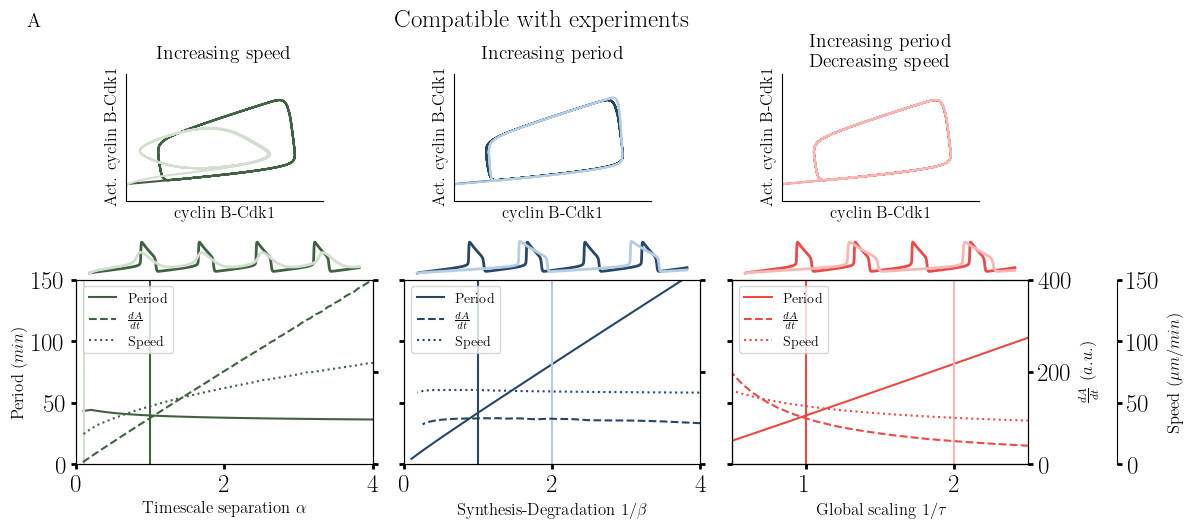

In [13]:

cols = [['#D2DECF','#6A966B','#416241'],
        ['#B5CCE3','#6796C5','#274768'],
        ['#F7B7B6','#EF6E6C','#EB4A47']]
cmap_0 = custom_colormap([cols[0][0],cols[0][2]])
cmap_1 = custom_colormap([cols[1][0],cols[1][2]])
cmap_2 = custom_colormap([cols[2][0],cols[2][2]])

in_0 = chang2013model(p_0) 
in_0.tf_timeseries = 150
in_0.nt_timeseries = 1000


plt.rcParams.update({'font.size': 12})
size = 8
fig = plt.figure(figsize=(1.6*size,2*size/3))#,constrained_layout=True)
nrow, ncol = 100,100
ax0 = plt.subplot2grid((nrow, ncol), (0, 5), rowspan = 31, colspan = 20)
ax1 = plt.subplot2grid((nrow, ncol), (0, 38), rowspan = 31, colspan = 20)
ax2 = plt.subplot2grid((nrow, ncol), (0, 71), rowspan = 31, colspan = 20)
ax3 = plt.subplot2grid((nrow, ncol), (50, 0), rowspan = 45, colspan = 30)
ax4 = plt.subplot2grid((nrow, ncol), (50, 33), rowspan = 45, colspan = 30)
ax5 = plt.subplot2grid((nrow, ncol), (50, 66), rowspan = 45, colspan = 30)
ax6 = plt.subplot2grid((nrow, ncol), (40, 0), rowspan = 10, colspan = 30)
ax7 = plt.subplot2grid((nrow, ncol), (40, 33), rowspan = 10, colspan = 30)
ax8 = plt.subplot2grid((nrow, ncol), (40, 66), rowspan = 10, colspan = 30)

tf, nt = 200,1000
in_1 = chang2013model(dict(p_0, alpha=1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax0,xlim=[40,80],ylim = [0,80],color = cols[0][2],axis=True)
plot_timeseries_fig2(in_1, ax6,color = cols[0][2])


in_1 = chang2013model(dict(p_0, alpha=.1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax0,xlim=[40,80],ylim = [0,80],color = cols[0][0],axis=True)
plot_timeseries_fig2(in_1, ax6,color = cols[0][0])

  
in_1 = chang2013model(dict(p_0, beta=1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax1,xlim=[40,80],ylim = [0,80],color = cols[1][2],axis=True)
plot_timeseries_fig2(in_1, ax7,color = cols[1][2])

in_1 = chang2013model(dict(p_0, beta=0.5))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax1,xlim=[40,80],ylim = [0,80],color = cols[1][0],axis=True)
plot_timeseries_fig2(in_1, ax7,color = cols[1][0])



in_1 = chang2013model(dict(p_0, tau=1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax2,xlim=[40,80],ylim = [0,80],color = cols[2][2],axis=True)
plot_timeseries_fig2(in_1, ax8,color = cols[2][2])

in_1 = chang2013model(dict(p_0, tau=0.5))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax2,xlim=[40,80],ylim = [0,80],color = cols[2][0],axis=True)
plot_timeseries_fig2(in_1, ax8,color = cols[2][0])


                     
folders = ['../sim/disp-rel/alpha_scan/param_speed_period.npy','../sim/alpha-period-amp.npy']
plot_period_dadt_speed(ax3,folders,chi,
                           labelx = r'Timescale separation $\alpha$',
                           col = cols[0][2],yaxis=True,twinxaxis=False,xrange=[0,4])

folders = ['../sim/disp-rel/beta_scan/param_speed_period.npy','../sim/beta-period-amp.npy']
plot_period_dadt_speed(ax4,folders,chi,
                           labelx = r'Synthesis-Degradation $1/\beta$',
                           col = cols[1][2],yaxis=False,twinxaxis=False,xrange=[0,4],inverse_param=True)

folders = ['../sim/disp-rel/tau_scan/param_speed_period.npy','../sim/tau-period-amp.npy']
plot_period_dadt_speed(ax5,folders,chi,
                           labelx = r'Global scaling $1/\tau$',
                           col = cols[2][2],yaxis=False,twinxaxis=True,xrange=[0.5,2.5],inverse_param=True)
ax3.axvline(.1,c=cols[0][0])
ax3.axvline(1,c=cols[0][2])

ax4.axvline(2,c=cols[1][0])
ax4.axvline(1,c=cols[1][2])

ax5.axvline(2,c=cols[2][0])
ax5.axvline(1,c=cols[2][2])

ax0.text(20,110,'A',fontsize=14,color='black',weight='bold')
ax1.text(58,110,'Compatible with experiments',fontsize=18,color='black',weight='bold',horizontalalignment='center')
ax0.text(60,90,'Increasing speed',fontsize=14,color='black',weight='bold',horizontalalignment='center')
ax1.text(60,90,'Increasing period',fontsize=14,color='black',weight='bold',horizontalalignment='center')
ax2.text(60,85,'Increasing period \n Decreasing speed',fontsize=14,color='black',weight='bold',horizontalalignment='center')

# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/fig2av0.pdf',bbox_inches='tight',dpi=300)

plt.show()